In [1]:
"""
version 01.02
* Have function of Classificaion of BSA adsorption

version 02.01
* Change the PyTorch into SKlearn
version 02.02
* Change the descriptors

"""

'\nversion 01.02\n* Have function of Classificaion of BSA adsorption\n\nversion 02.01\n* Change the PyTorch into SKlearn\nversion 02.02\n* Change the descriptors\n\n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import shap

from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

from joblib import dump, load
import os

shap.initjs()
os.makedirs('models', exist_ok=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
raw = pd.read_csv("250201_All_exp_value.csv")
raw

Protein adsorption / ng cm-2  Protein MW (kDa)  Protein Charge (pI)  \
0                           992.0              66.5                  4.7   
1                           396.5              66.5                  4.7   
2                           400.6              66.5                  4.7   
3                           391.5              66.5                  4.7   
4                             8.9              66.5                  4.7   
..                            ...               ...                  ...   
96                            0.0             340.0                  5.8   
97                          254.0             340.0                  5.8   
98                          567.2             340.0                  5.8   
99                          125.1             340.0                  5.8   
100                          63.0             340.0                  5.8   

     Protein conc. (mg/mL)  Thickness (nm)  Predicted Zeta (mV)  \
0                      1.0           13.80            16.319553   
1                      1.0           19.50             7.166369   
2                      1.0           10.30            -9.967725   
3                      1.0           15.20           -29.943920   
4                      1.0           20.20           -18.314512   
..                     ...             ...                  ...   
96                     NaN           12.49            -1.272445   
97                     NaN           18.93           -51.277580   
98                     NaN           22.40           -15.430634   
99                     NaN           40.10            -9.828280   
100                    NaN           50.00           -12.517403   

     Predicted CA (deg)  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0             16.000903          10.784035       10.784035           0.313102   
1             65.901976          65.901976       11.123746          11.123746   
2             74.526047          10.421065       10.421065           0.312500   
3             82.069702          10.631481       10.631481           0.047037   
4             42.474985          11.141062       11.141062           0.204506   
..                  ...                ...             ...                ...   
96            12.318509                NaN             NaN                NaN   
97            13.966482                NaN             NaN                NaN   
98            48.254231                NaN             NaN                NaN   
99            50.506325                NaN             NaN                NaN   
100           25.857781                NaN             NaN                NaN   

     ...  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0    ...           0.0         0.0                0.0           0.0   
1    ...           0.0         0.0                0.0           0.0   
2    ...           0.0         0.0                0.0           0.0   
3    ...           0.0         0.0                0.0           0.0   
4    ...           0.0         0.0                0.0           0.0   
..   ...           ...         ...                ...           ...   
96   ...           NaN         NaN                NaN           NaN   
97   ...           NaN         NaN                NaN           NaN   
98   ...           NaN         NaN                NaN           NaN   
99   ...           NaN         NaN                NaN           NaN   
100  ...           NaN         NaN                NaN           NaN   

     fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0            0.0          0.0           0.0               0.0      0.0   
1            0.0          0.0           0.0               0.0      0.0   
2            0.0          0.0           0.0               0.0      0.0   
3            0.0          0.0           0.0               0.0      0.0   
4            0.0          0.0           0.0              25.0      0.0   
..           ... 

In [4]:
df = raw[:53]

df_label = df["Protein adsorption / ng cm-2"]

df = df.drop("Protein adsorption / ng cm-2", axis=1)
df.head()

Protein MW (kDa)  Protein Charge (pI)  Protein conc. (mg/mL)  \
0              66.5                  4.7                    1.0   
1              66.5                  4.7                    1.0   
2              66.5                  4.7                    1.0   
3              66.5                  4.7                    1.0   
4              66.5                  4.7                    1.0   

   Thickness (nm)  Predicted Zeta (mV)  Predicted CA (deg)  MaxAbsEStateIndex  \
0            13.8            16.319553           16.000903          10.784035   
1            19.5             7.166369           65.901976          65.901976   
2            10.3            -9.967725           74.526047          10.421065   
3            15.2           -29.943920           82.069702          10.631481   
4            20.2           -18.314512           42.474985          11.141062   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  ...  fr_sulfonamd  \
0       10.784035           0.313102       -0.313102  ...           0.0   
1       11.123746          11.123746        0.000000  ...           0.0   
2       10.421065           0.312500       -0.312500  ...           0.0   
3       10.631481           0.047037       -0.314815  ...           0.0   
4       11.141062           0.204506       -0.409403  ...           0.0   

   fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0         0.0                0.0           0.0          0.0          0.0   
1         0.0                0.0           0.0          0.0          0.0   
2         0.0                0.0           0.0          0.0          0.0   
3         0.0                0.0           0.0          0.0          0.0   
4         0.0                0.0           0.0          0.0          0.0   

   fr_thiophene  fr_unbrch_alkane  fr_urea  Unnamed: 217  
0           0.0               0.0      0.0           NaN  
1           0.0               0.0      0.0           0.0  
2           0.0               0.0      0.0           NaN  
3           0.0               0.0      0.0           NaN  
4           0.0              25.0      0.0           NaN  

[5 rows x 217 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


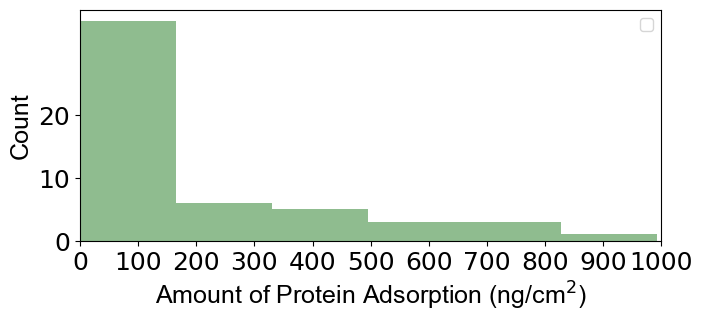

In [5]:
number_of_bins = 6
plt.figure(figsize=(7.5, 3))
plt.rcParams["font.size"] = 18
plt.hist(df_label, bins=number_of_bins, color=["darkseagreen"], edgecolor=None, stacked=False, alpha=1)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Amount of Protein Adsorption (ng/cm$^2$)", font="Arial")
plt.ylabel("Count", font="Arial")
plt.xlim(0, 1000)
plt.xticks(np.arange(0, 1050, 100))
plt.yticks(np.arange(0,30,10))
plt.show()

In [7]:
def gen_fig1(model_name, X_train, Y_train, X_val, Y_val, RMSE_train, RMSE_val, r2_train, r2_test):
    #model_name = str(model_name)
    fig,ax=plt.subplots(figsize=(6, 6), dpi=300)
    Axis_line=np.linspace(*ax.get_xlim(),2)
    ax.plot(Axis_line,Axis_line,transform=ax.transAxes,linestyle='--',
            linewidth=2,color='black',label="1:1 Line")
    ax.set_xlim([0, 1100])
    ax.set_ylim([0, 1100])
    
    scatter1 = ax.scatter(X_train, Y_train, color='salmon', alpha=0.5, label="Training set")
    scatter2 = ax.scatter(X_val, Y_val, color='steelblue', alpha=0.5, label="Test set")
    plt.legend(handles=[scatter1, scatter2], labels = ["Training set", "Test set"], loc="lower right", fontsize=14, fancybox=True, markerscale=0.8, framealpha=0.8, handlelength=0.5)
    
    ax.text(25, 1075, " Score of "+model_name+" "
            "\n $RMSE$ (training): "+str(round(RMSE_train, 2))+" "
            "\n $RMSE$ (test): "+str(round(RMSE_val, 2))+" "
            #"\n $R^2$ of training set: "+str(round(r2_train, 2))+" "
            "\n $R\u00b2$ (training): "+str(round(r2_train, 2))+" "
            "\n $R\u00b2$ (test): "+str(round(r2_test, 2))+" ",
            verticalalignment='top', horizontalalignment='left',fontsize=20,
            bbox={'facecolor': 'lightskyblue', 'alpha': 0.2, 'pad': 1})
    
    plt.xlabel("Reported BSA Adsorption", fontsize=20, fontweight='bold', font="Arial")
    plt.ylabel("Predicted BSA Adsorption", fontsize=20, fontweight='bold', font="Arial")
    new_ticks = [0, 200, 400, 600, 800, 1000]
    #new_ticks = np.linspace(-75, 100, 9)
    plt.xticks(new_ticks, fontweight='bold')
    plt.yticks(new_ticks, fontweight='bold')
    ax.tick_params(labelsize="16", direction="in")
    
    plt.rcParams['axes.titley'] = 1.03
    #plt.title(model_name, fontsize=26,fontweight='bold',font="Arial", color='black')
    
    plt.show()
    plt.clf()
    
def result_show(model, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    
    model.fit(X_part_array, Y_part_array)
    Y_predict = model.predict(X_val_array)
    Y_part_predict = model.predict(X_part_array)
    
    RMSE_val = np.sqrt(mean_squared_error(Y_val_array, Y_predict))
    RMSE_train = np.sqrt(mean_squared_error(Y_part_array, Y_part_predict))
    # sns.distplot(Y_predict-Y_val_array)
    r2_train = r2_score(Y_part_array, Y_part_predict)
    r2_test = r2_score(Y_val_array, Y_predict)  
        
    gen_fig1(model_name, Y_part_array, Y_part_predict, Y_val_array, Y_predict, RMSE_train, RMSE_val, r2_train, r2_test)
    
    return model

A

In [8]:

selected_a = ["Thickness (nm)",
              "MolLogP",
              "PEOE_VSA6", "PEOE_VSA7", "PEOE_VSA8", "PEOE_VSA9", "PEOE_VSA10",
              "TPSA",
              "Protein conc. (mg/mL)"]
df_a = df[selected_a]

df_a.head()

Thickness (nm)  MolLogP  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8   PEOE_VSA9  \
0            13.8   0.6673   6.578936  21.019081  12.117861    0.000000   
1            19.5   0.0000   0.000000   6.578936  34.618686    5.573105   
2            10.3   1.1256   6.578936  13.847474   5.573105    6.606882   
3            15.2   1.5141   6.578936  20.771212   5.573105    6.103966   
4            20.2   0.8849   6.578936   6.923737  12.682902  112.316993   

   PEOE_VSA10    TPSA  Protein conc. (mg/mL)  
0    6.606882   29.54                    1.0  
1   17.143896    0.00                    1.0  
2    0.000000   26.30                    1.0  
3    0.000000   26.30                    1.0  
4    6.606882  109.37                    1.0

In [9]:
scaler = MaxAbsScaler()
X_a = scaler.fit_transform(df_a)
X_a = np.array(X_a)

Y = np.array(df_label)

X_part_a, X_val_a, Y_part_array, Y_val_array = train_test_split(X_a, Y, test_size=0.2, random_state=42)


In [10]:
param_lasso = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_ridge = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_tree = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 10, 1),
             "random_state": [42]}

param_forest = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 5, 1),
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

param_knn = {"n_neighbors": np.arange(1, 15),
              "weights": ["uniform", "distance"]}

param_svr = {"C": [0.1, 1, 10, 100, 1000],
              "epsilon": [0.01, 0.1, 1, 10],
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}

param_xgb = {"max_depth": np.arange(1, 20),
             "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

models_param = {
    "Lasso": {"model": Lasso(), "param": param_lasso},
    "Ridge": {"model": Ridge(), "param": param_ridge},
    "Decision Tree": {"model": DecisionTreeRegressor(), "param": param_tree},
    "Random Forest": {"model": RandomForestRegressor(), "param": param_forest},
    "kNN": {"model": KNeighborsRegressor(), "param": param_knn},
    "SVR": {"model": SVR(), "param": param_svr},
    "XGBoost": {"model": XGBRegressor(), "param": param_xgb}
}

optimized_models = {"Lasso":{"scores":[]},
                    "Ridge":{"scores":[]},
                    "Decision Tree":{"scores":[]},
                    "Random Forest":{"scores":[]},
                    "kNN":{"scores":[]},
                    "SVR":{"scores":[]},
                    "XGBoost":{"scores":[]}}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
loo = LeaveOneOut()

In [11]:
trained_models_a = []

for model_name, model_param in models_param.items():
    print("Training "+model_name+"...")
    model = model_param["model"]
    param = model_param["param"]
    
    grid = GridSearchCV(model, param, cv=outer_cv, n_jobs=-1)
    grid.fit(X_part_a, Y_part_array)
    #grid_models_peoe.append(grid)
    print("Best parameters for "+model_name, grid.best_params_)
    model_ = grid.best_estimator_
    # dump(model_peoe, model_name+"_peoe.joblib")
    trained_models_a.append(model_)

    print("-------------------------NEXT-------------------------")

Training Lasso...
Best parameters for Lasso {'alpha': 2.99, 'fit_intercept': True}
-------------------------NEXT-------------------------
Training Ridge...
Best parameters for Ridge {'alpha': 1.2200000000000002, 'fit_intercept': False}
-------------------------NEXT-------------------------
Training Decision Tree...
Best parameters for Decision Tree {'max_depth': 2, 'min_samples_leaf': 5, 'random_state': 42}
-------------------------NEXT-------------------------
Training Random Forest...
Best parameters for Random Forest {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 50, 'random_state': 42}
-------------------------NEXT-------------------------
Training kNN...
Best parameters for kNN {'n_neighbors': 3, 'weights': 'distance'}
-------------------------NEXT-------------------------
Training SVR...
Best parameters for SVR {'C': 100, 'epsilon': 0.01, 'kernel': 'poly'}
-------------------------NEXT-------------------------
Training XGBoost...
Best parameters for XGBoost {'learning_ra

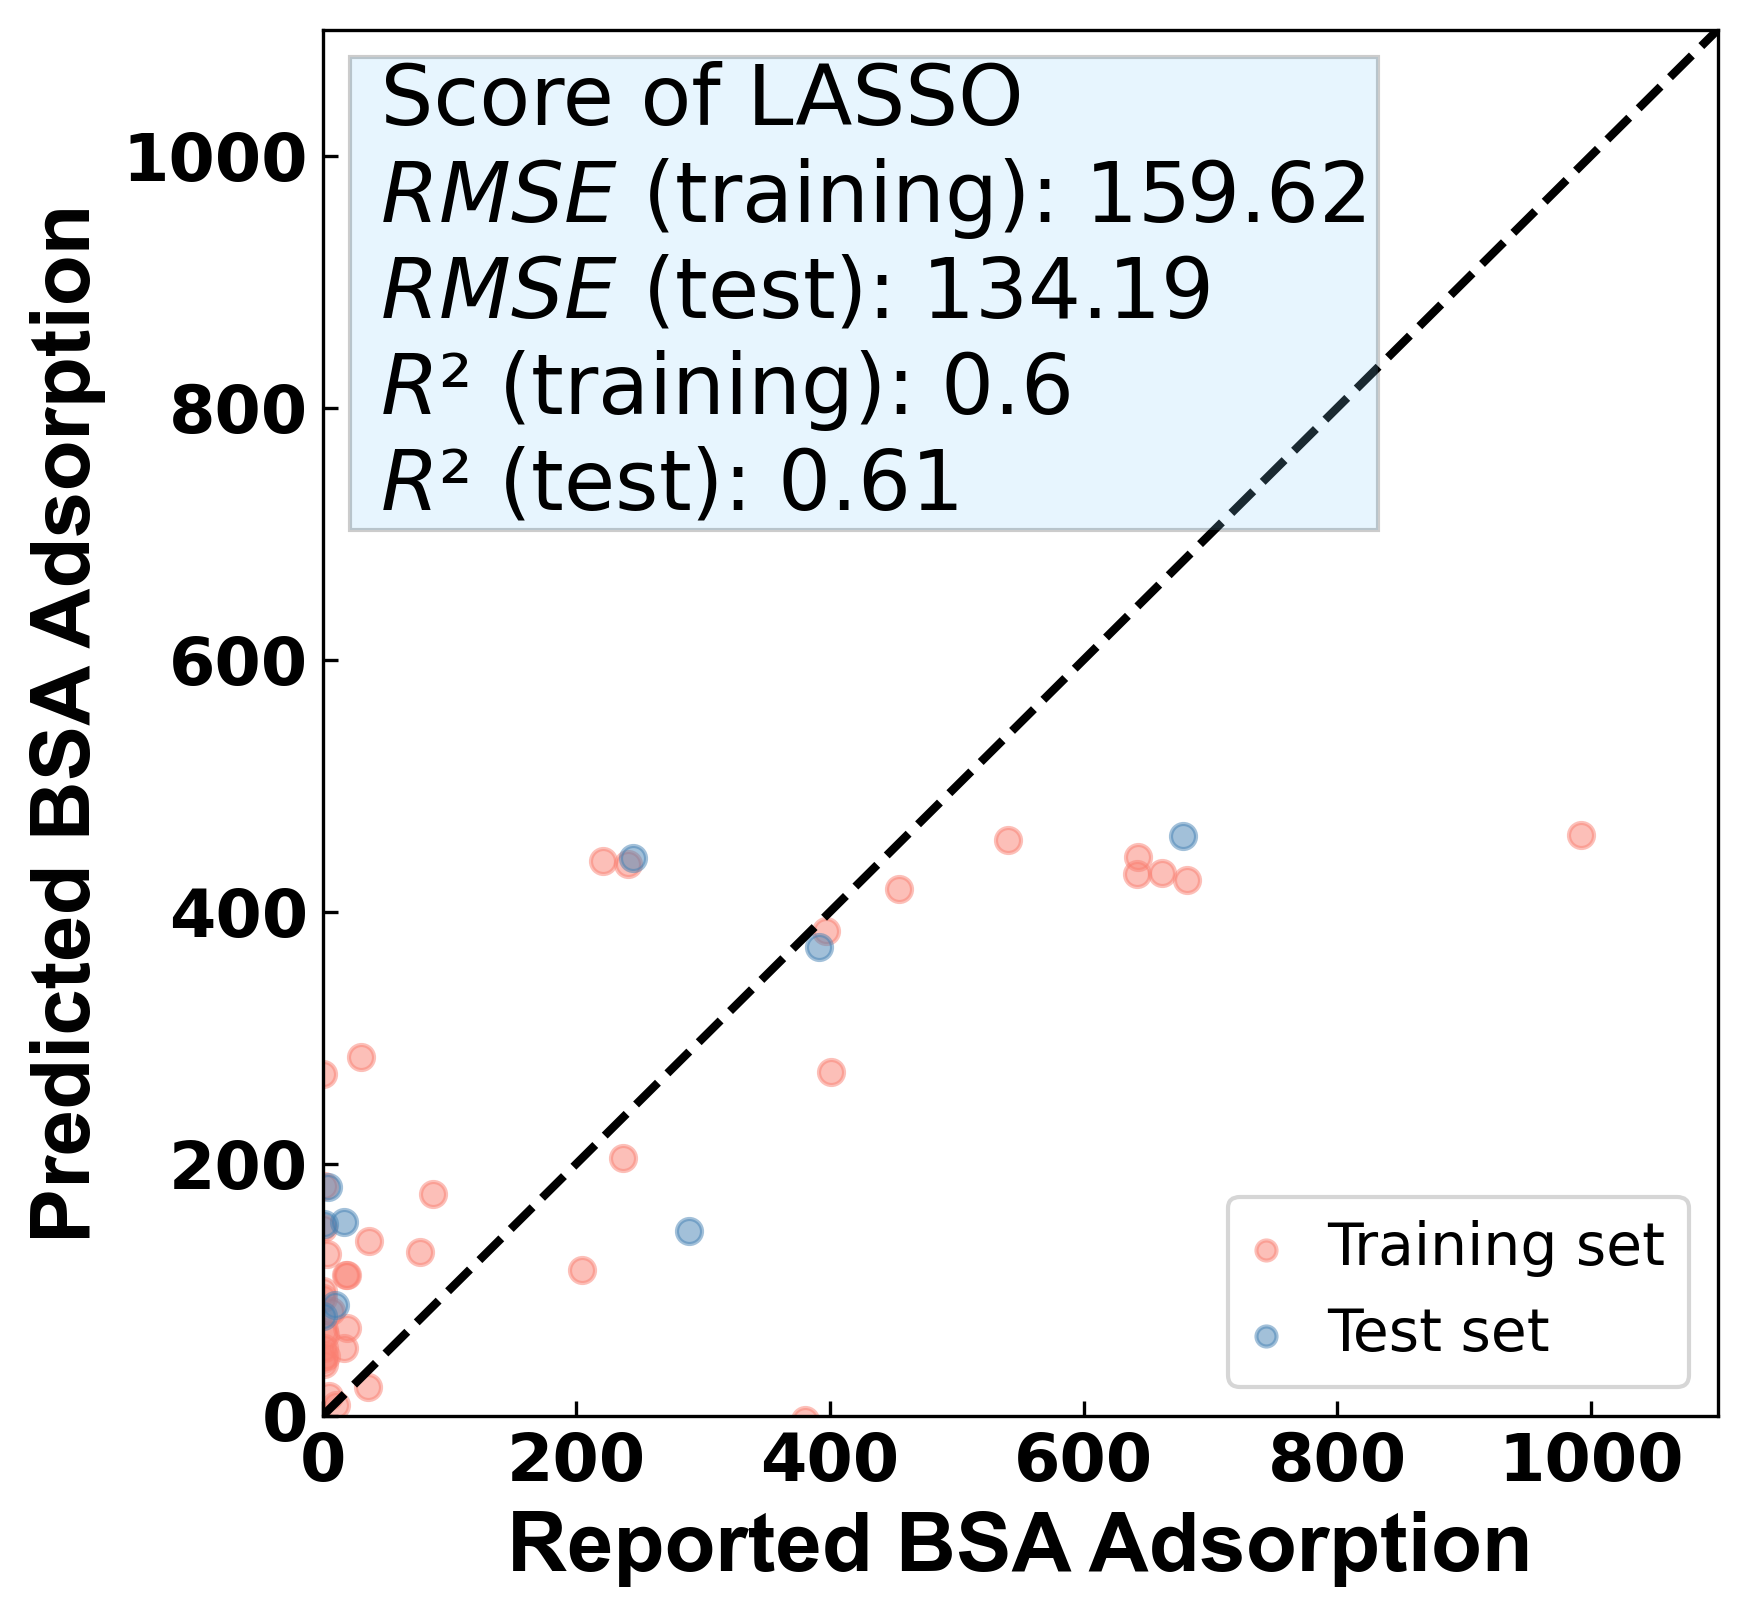

<Figure size 640x480 with 0 Axes>

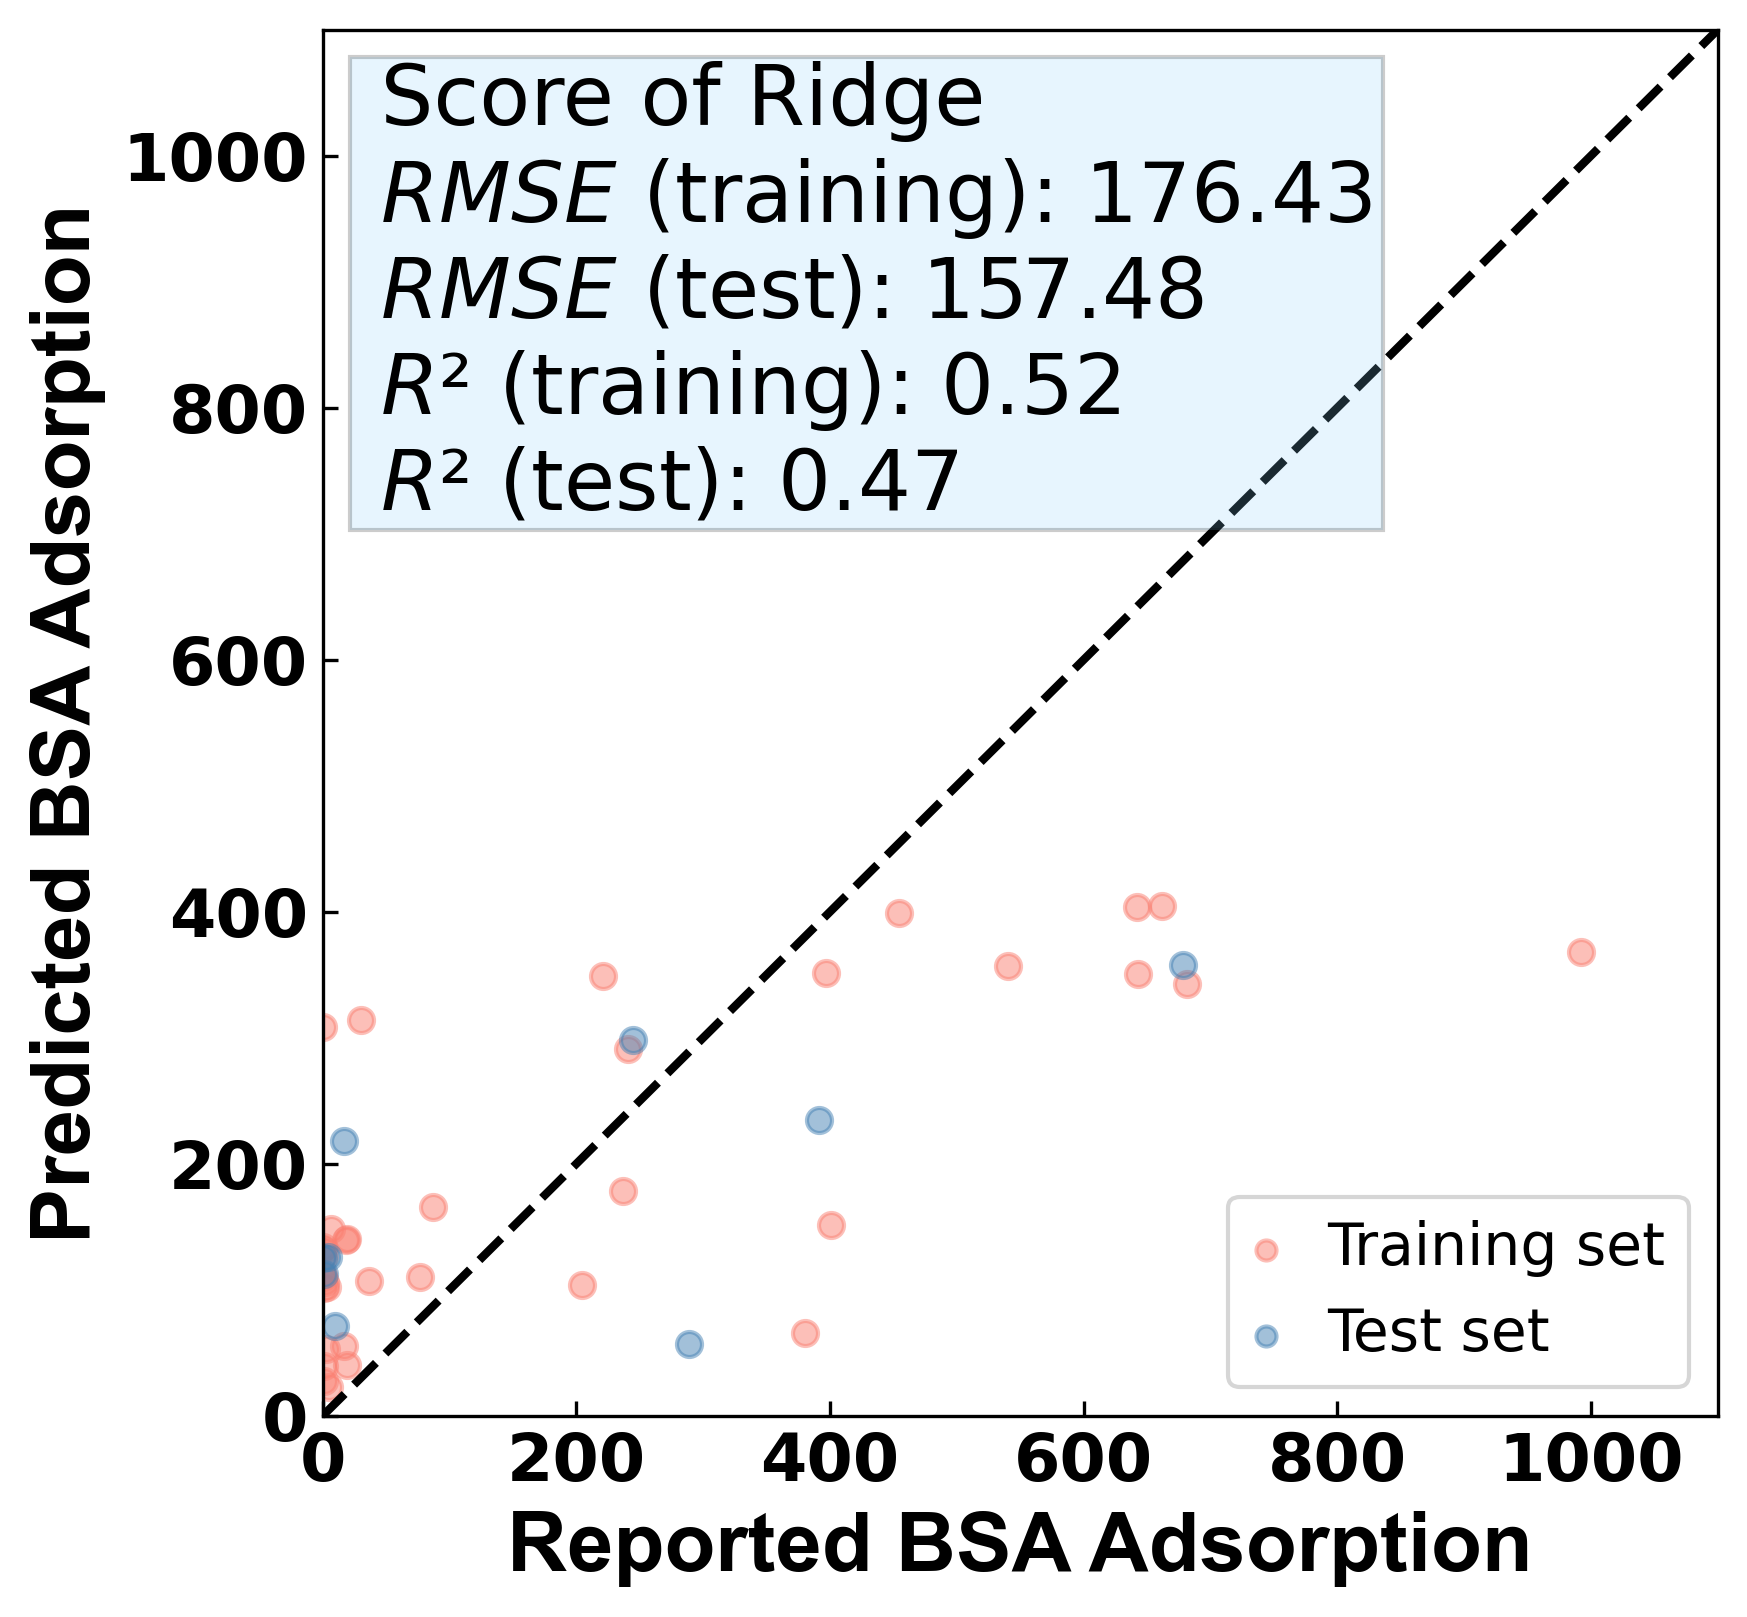

<Figure size 640x480 with 0 Axes>

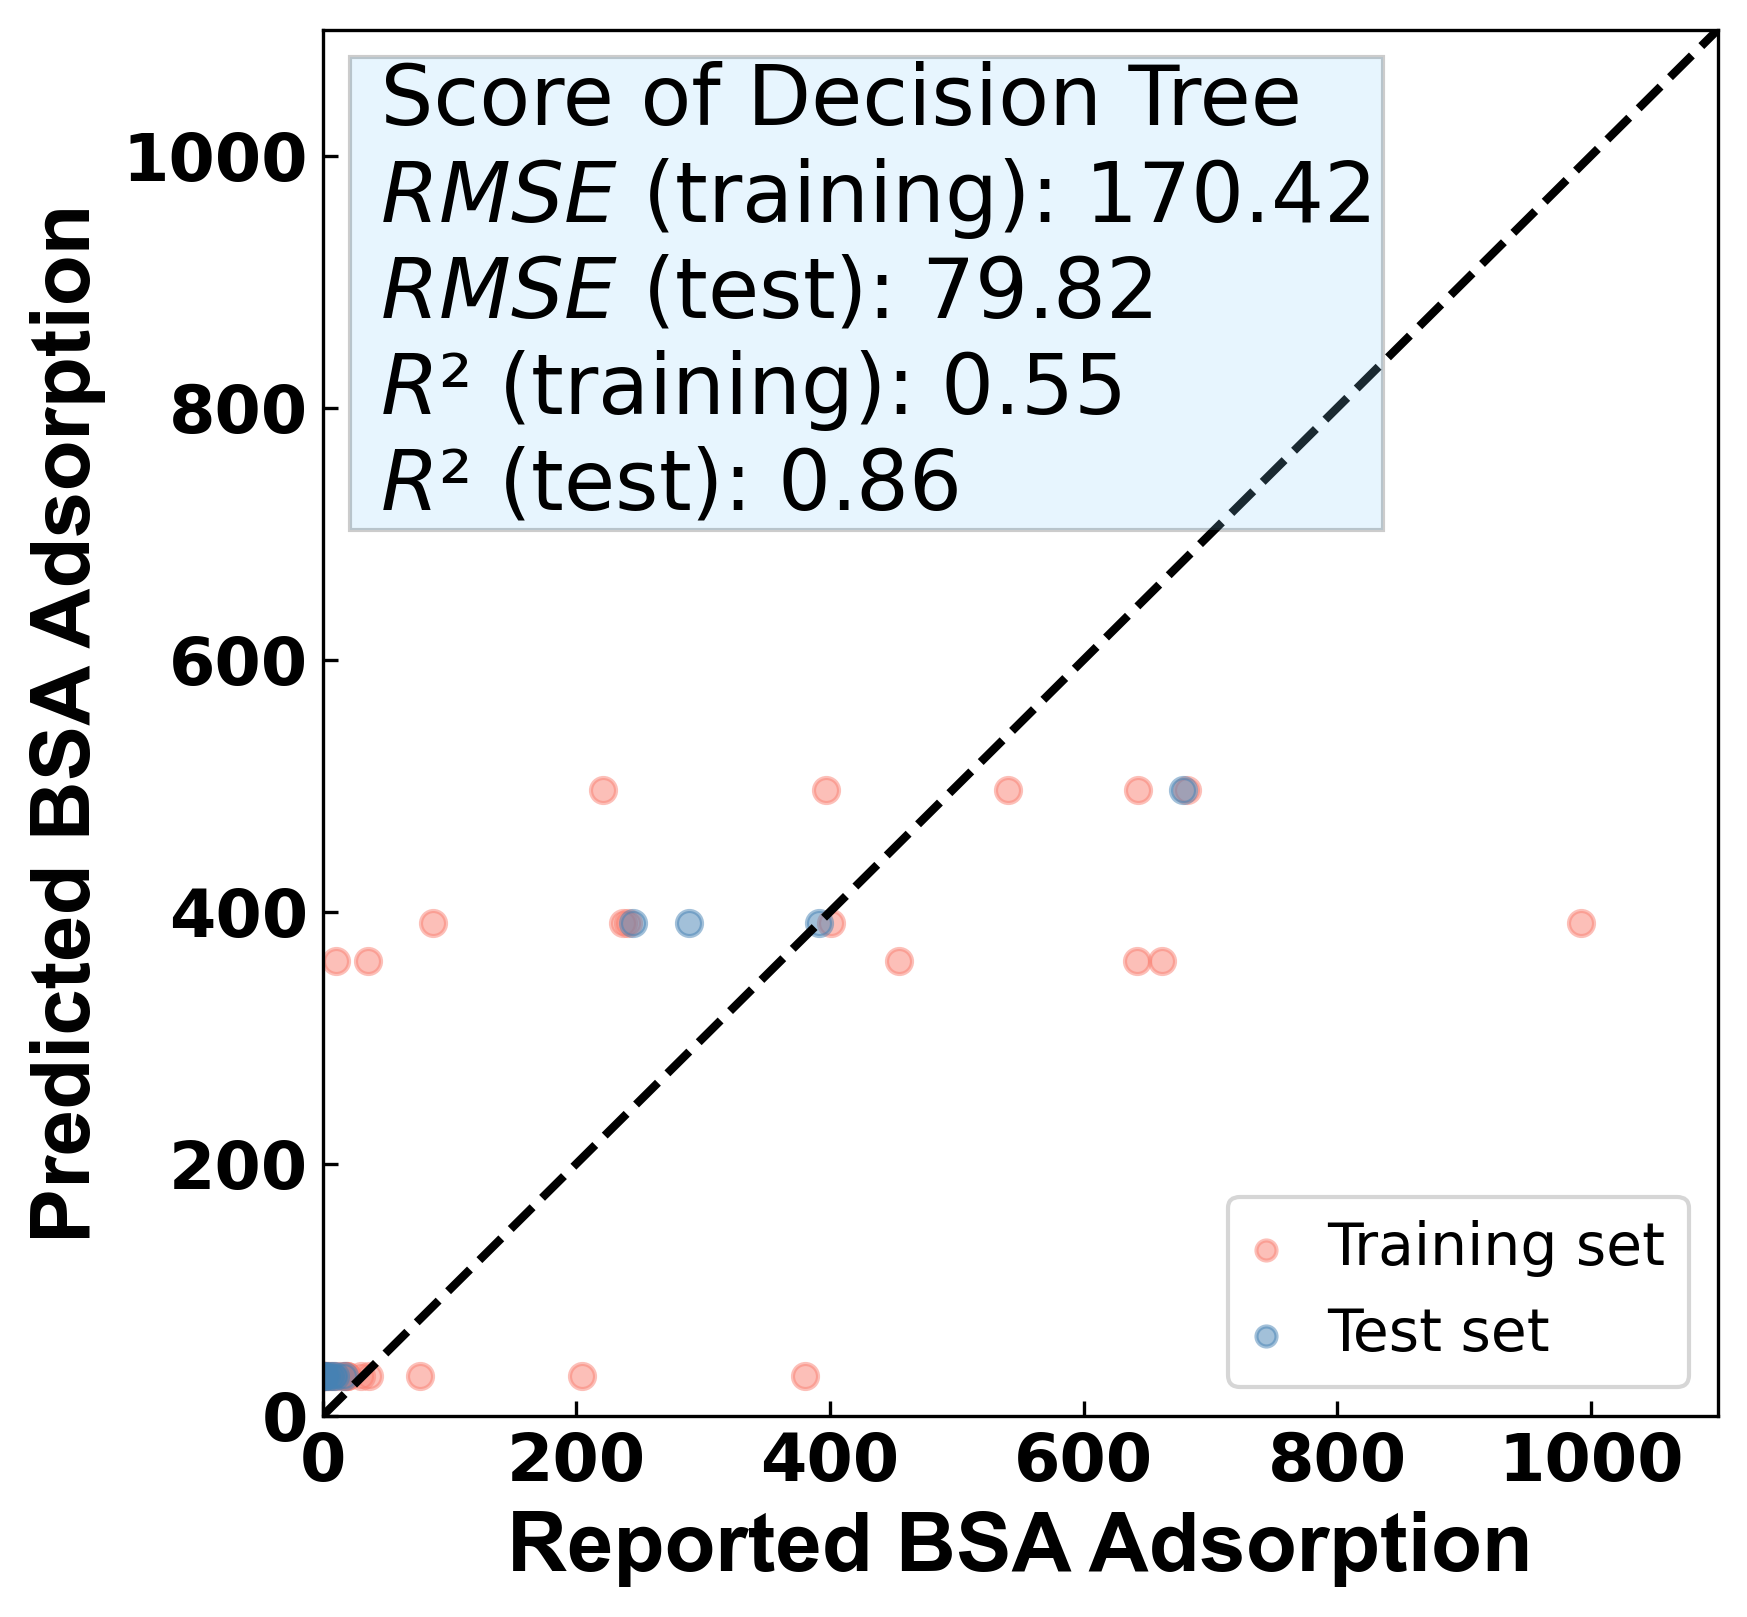

<Figure size 640x480 with 0 Axes>

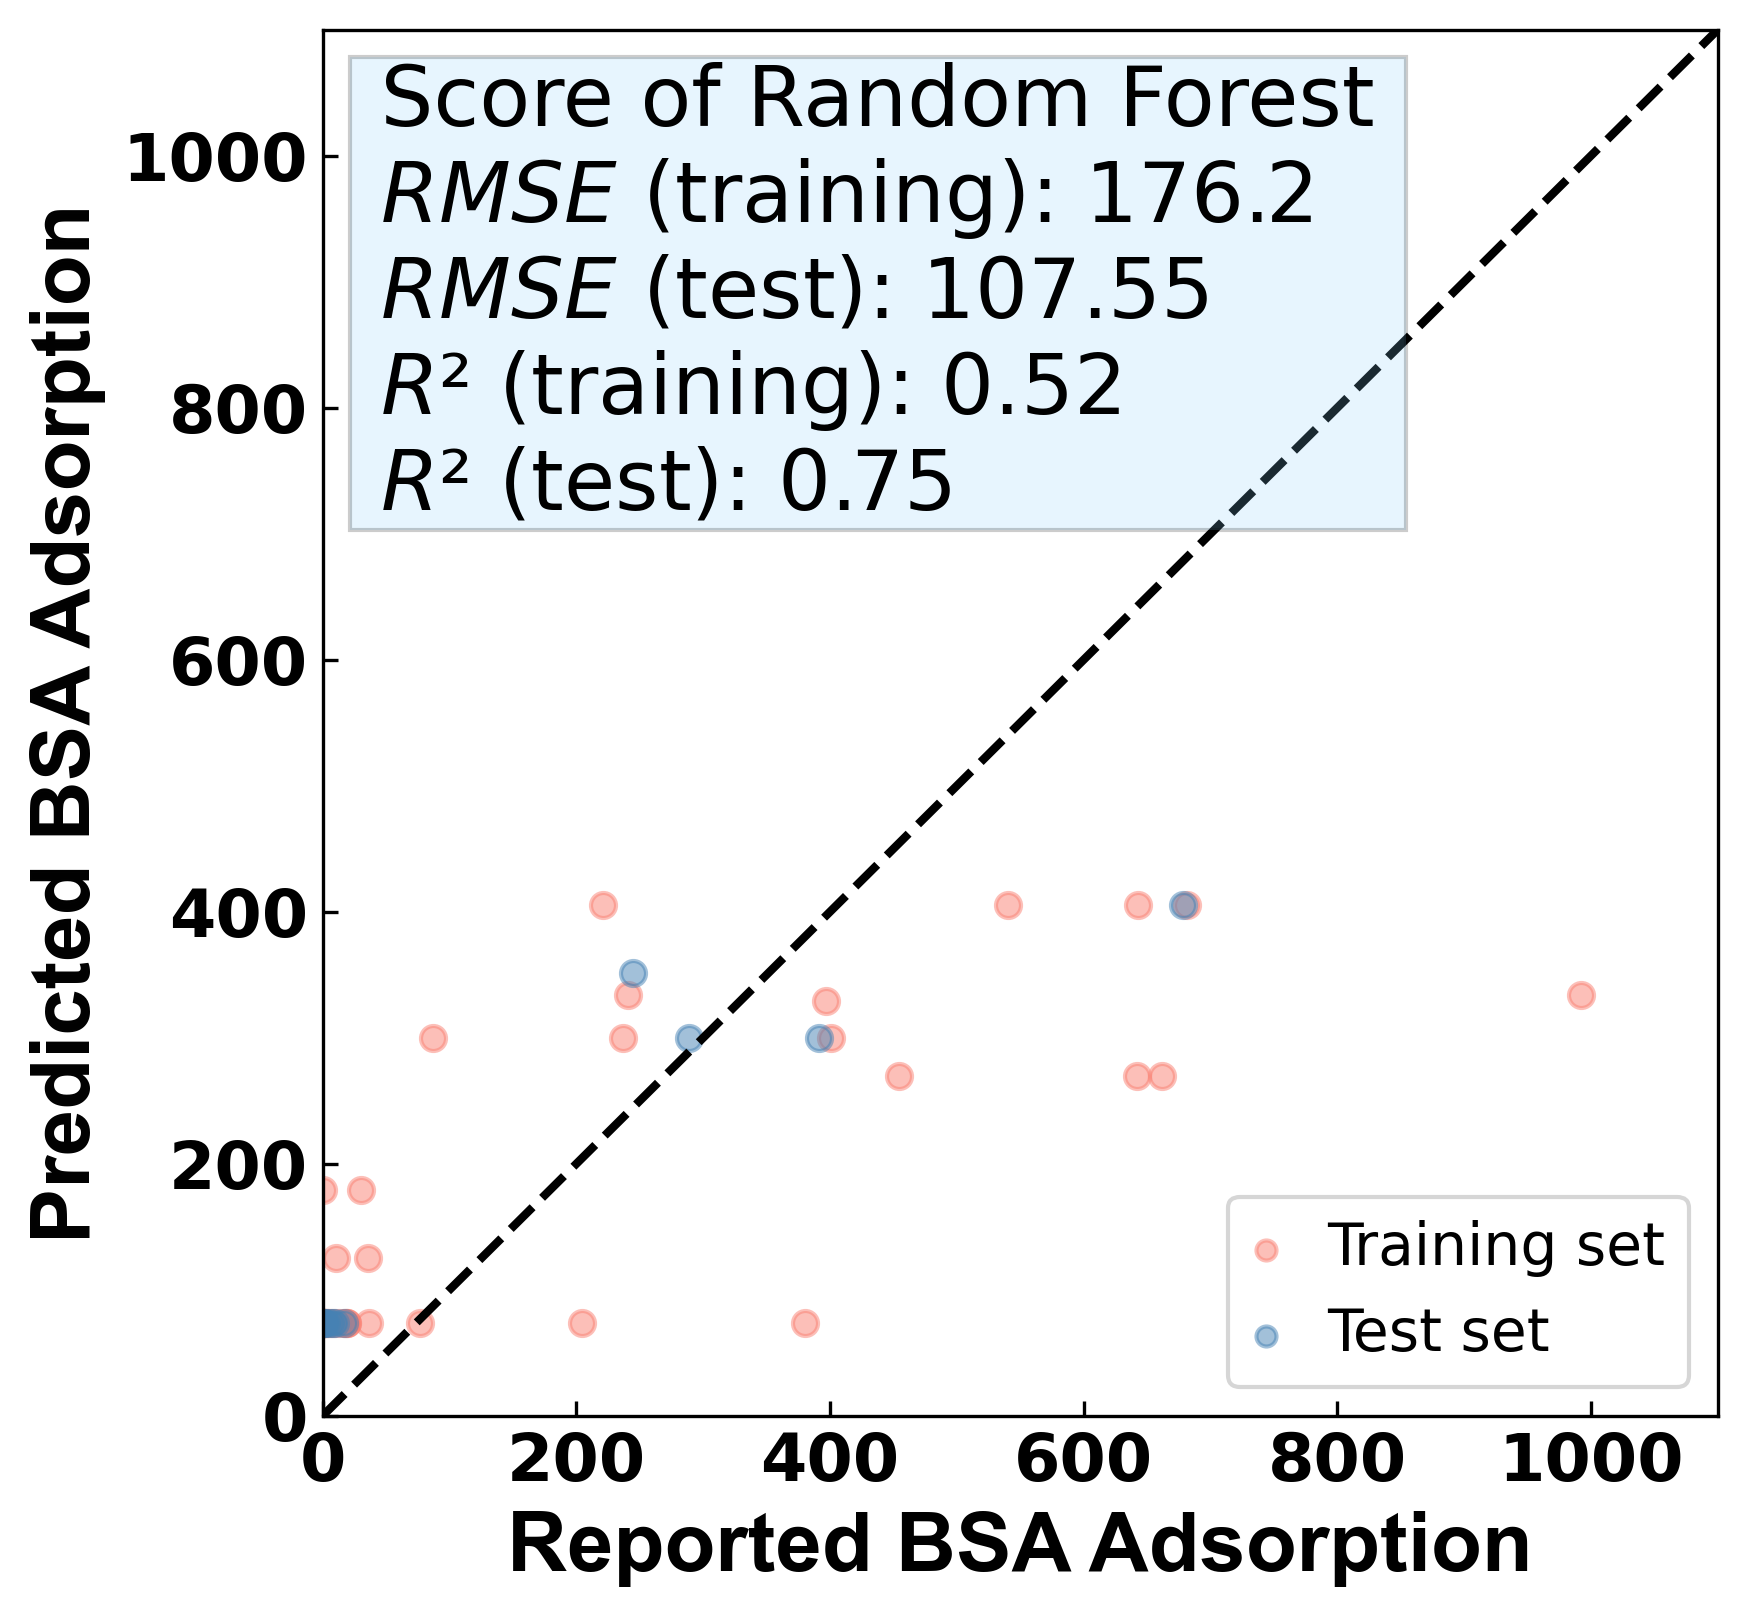

<Figure size 640x480 with 0 Axes>

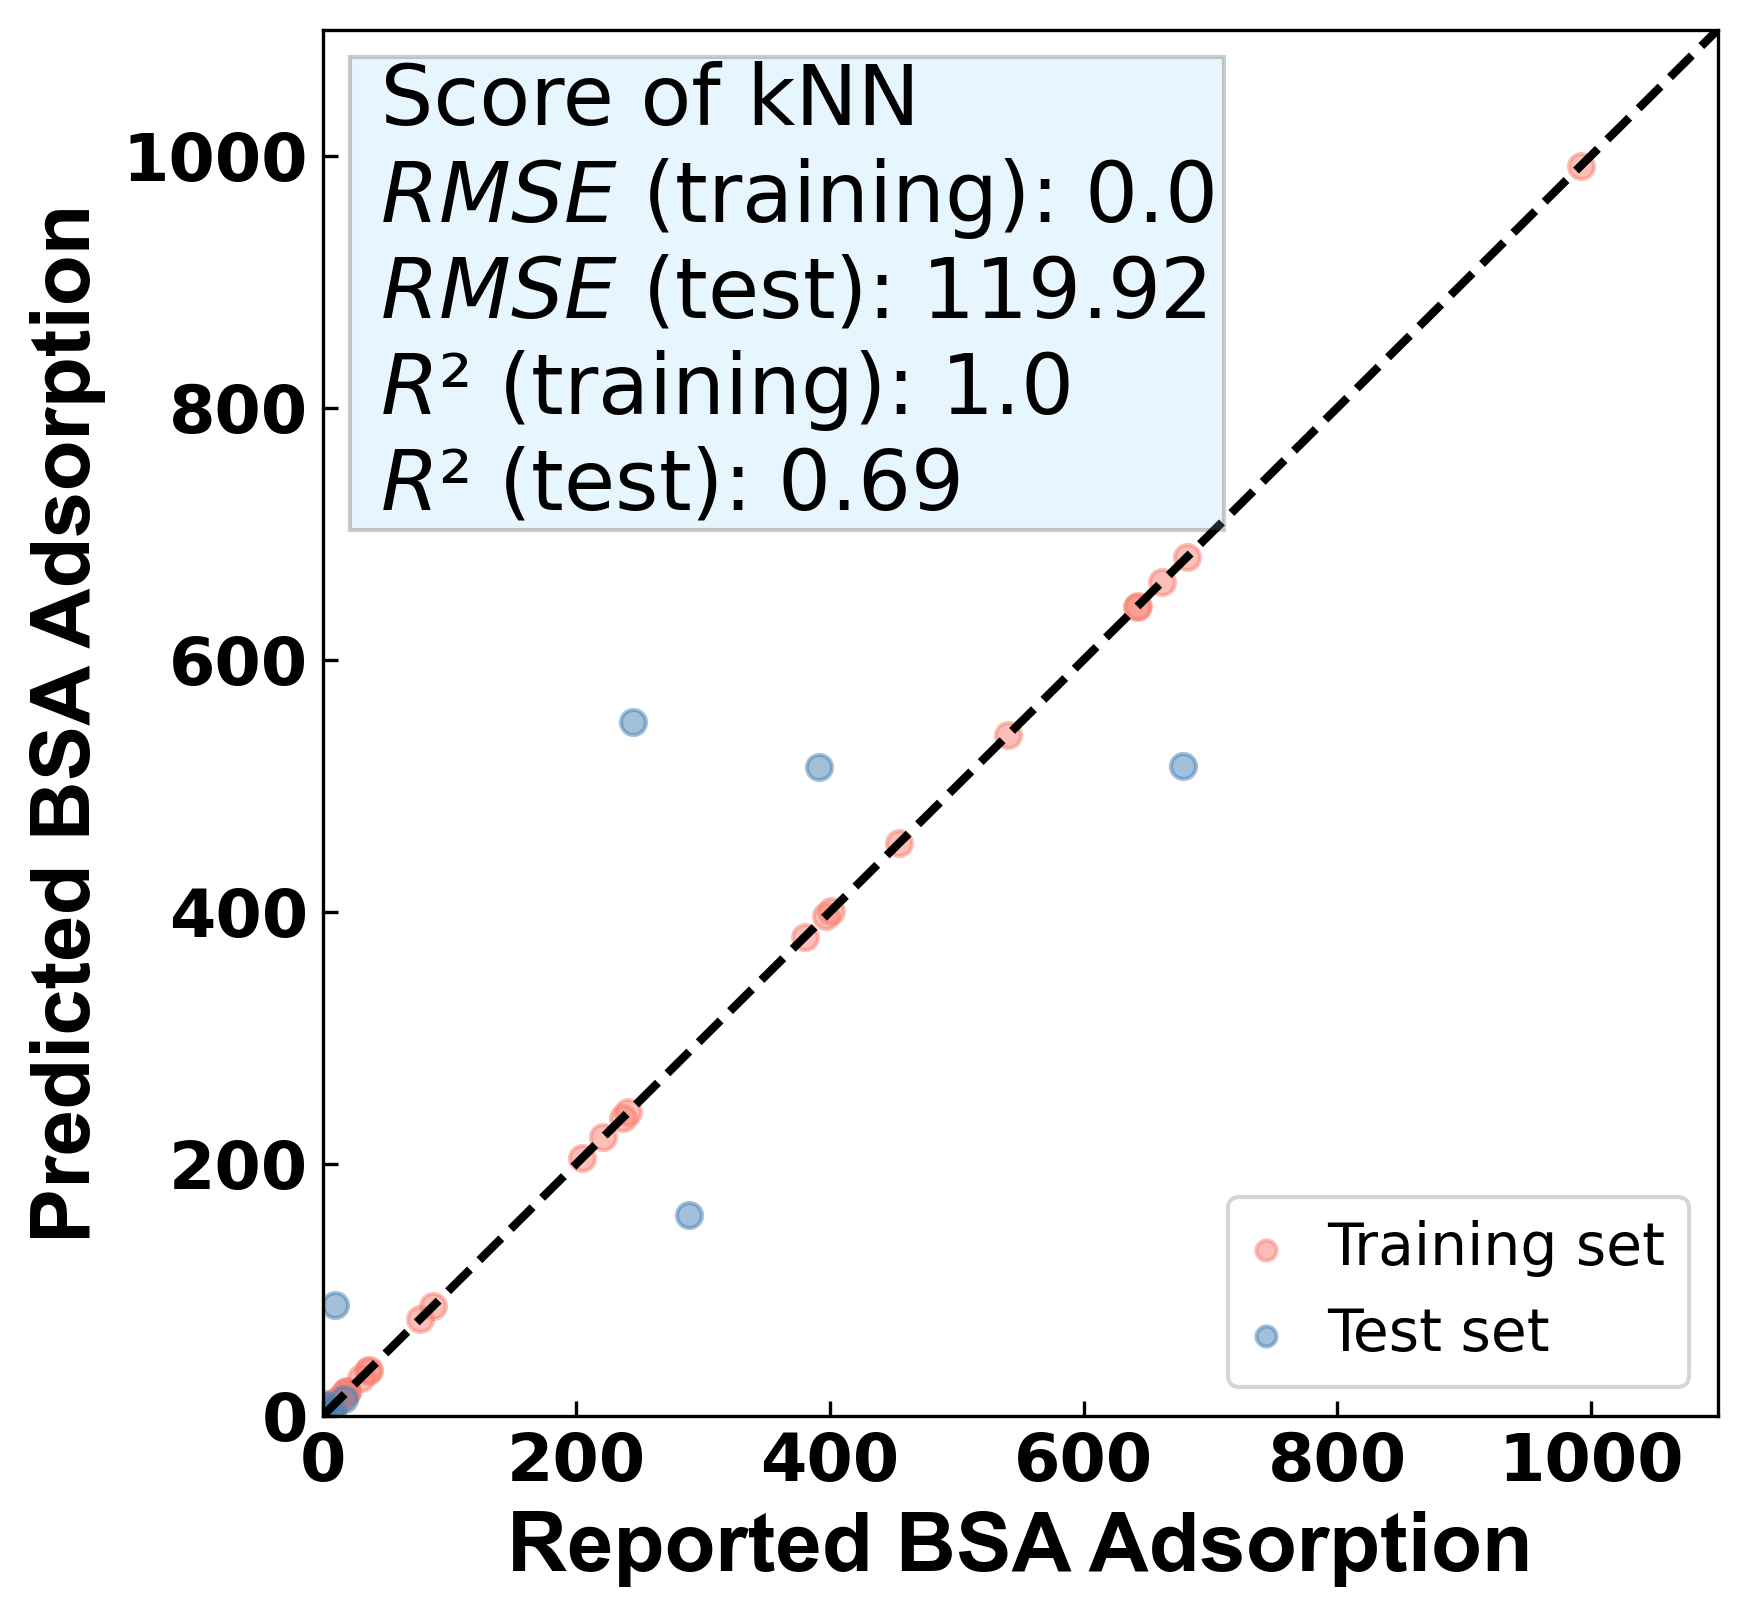

<Figure size 640x480 with 0 Axes>

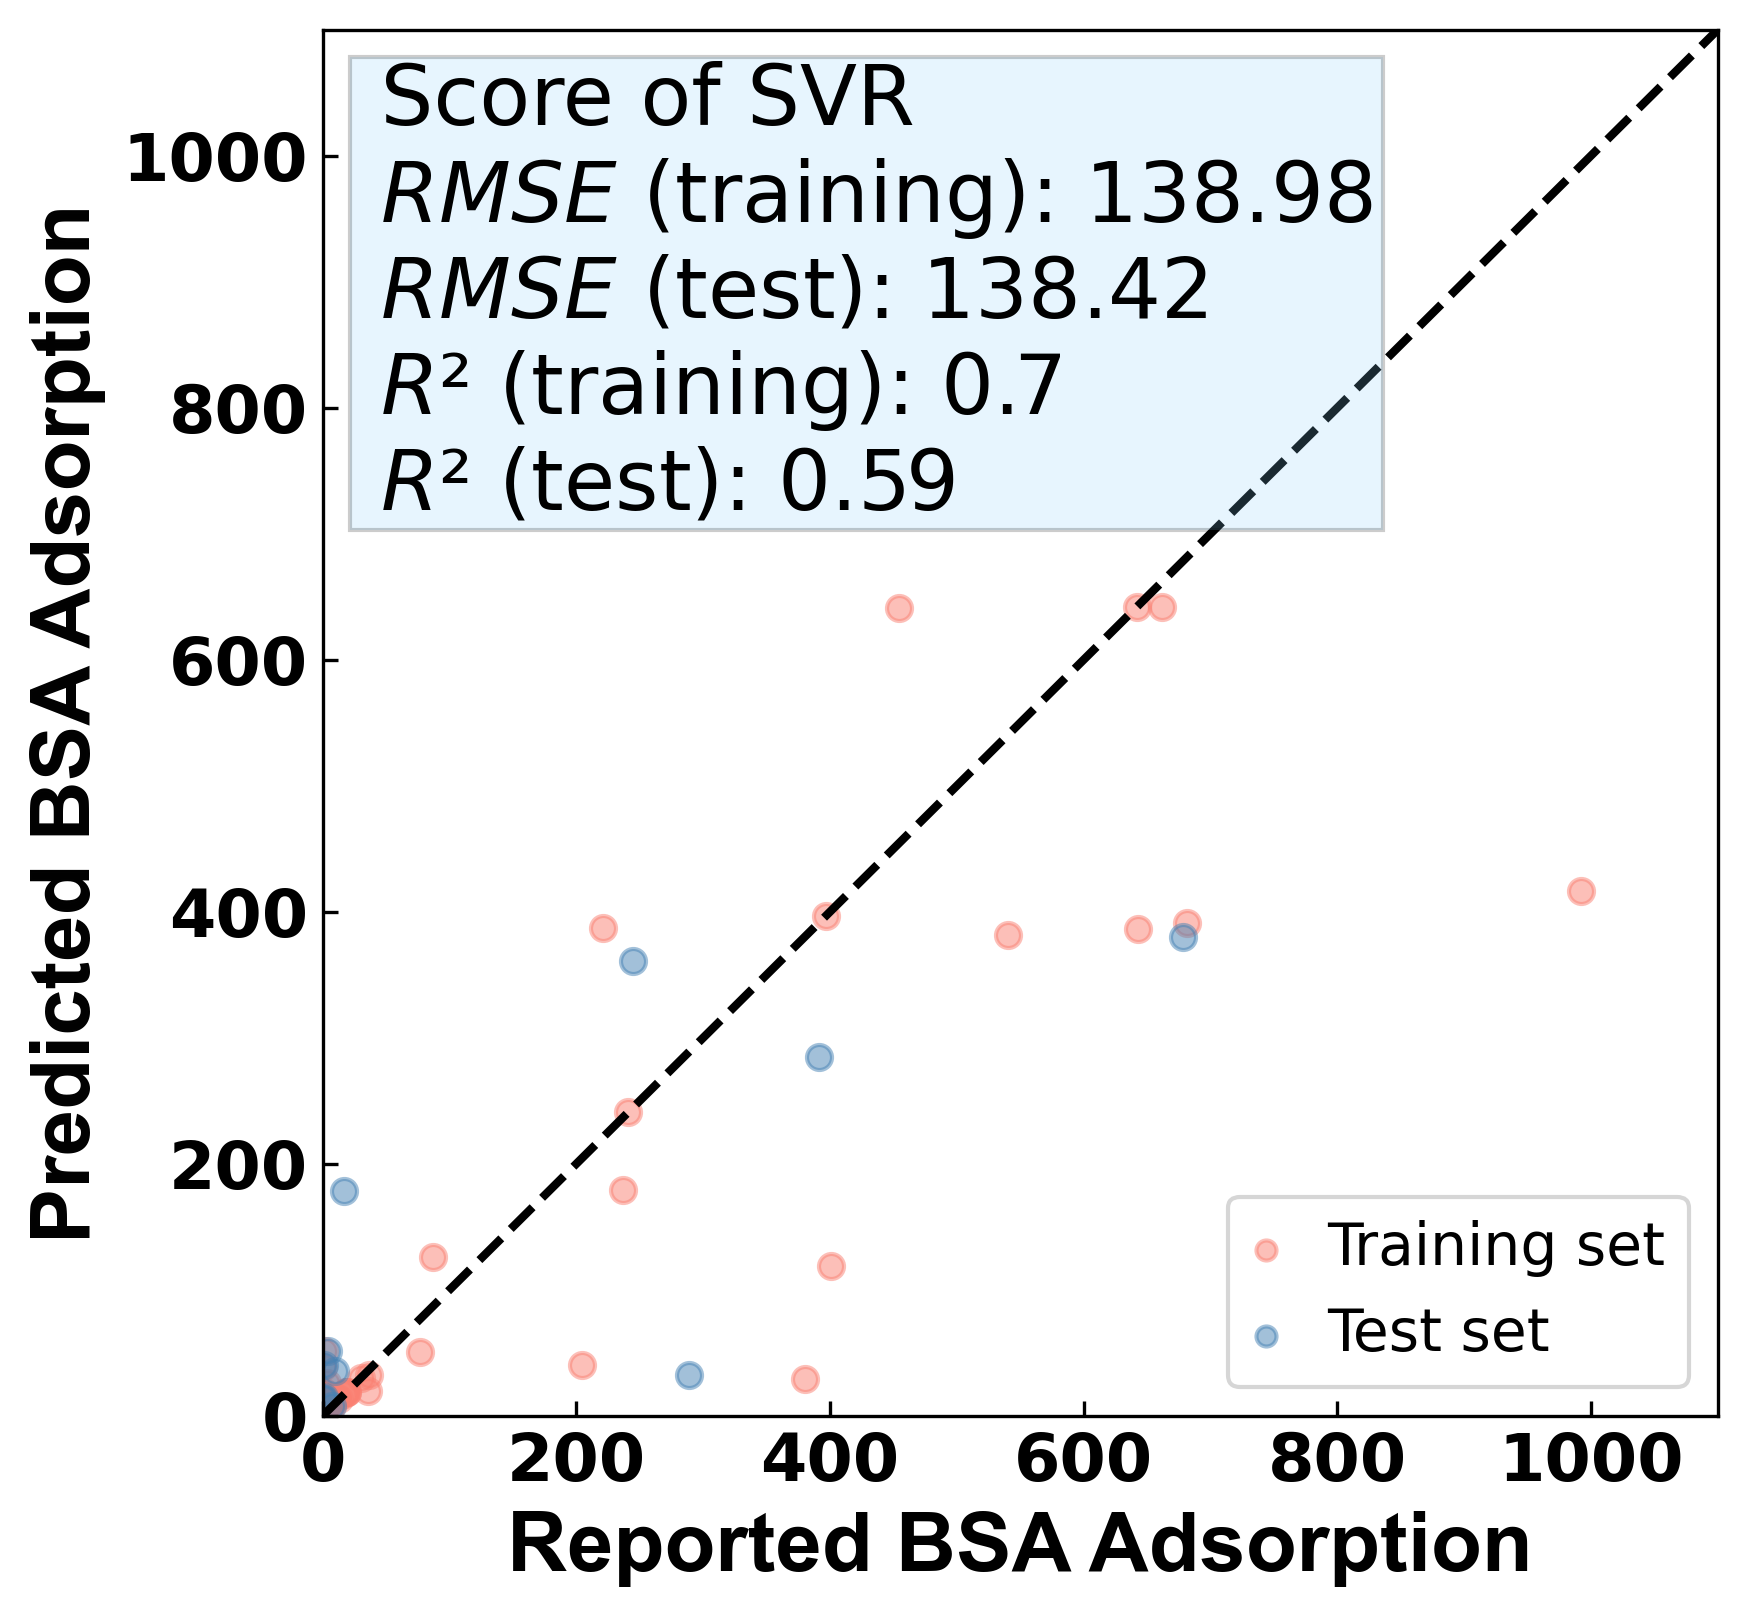

<Figure size 640x480 with 0 Axes>

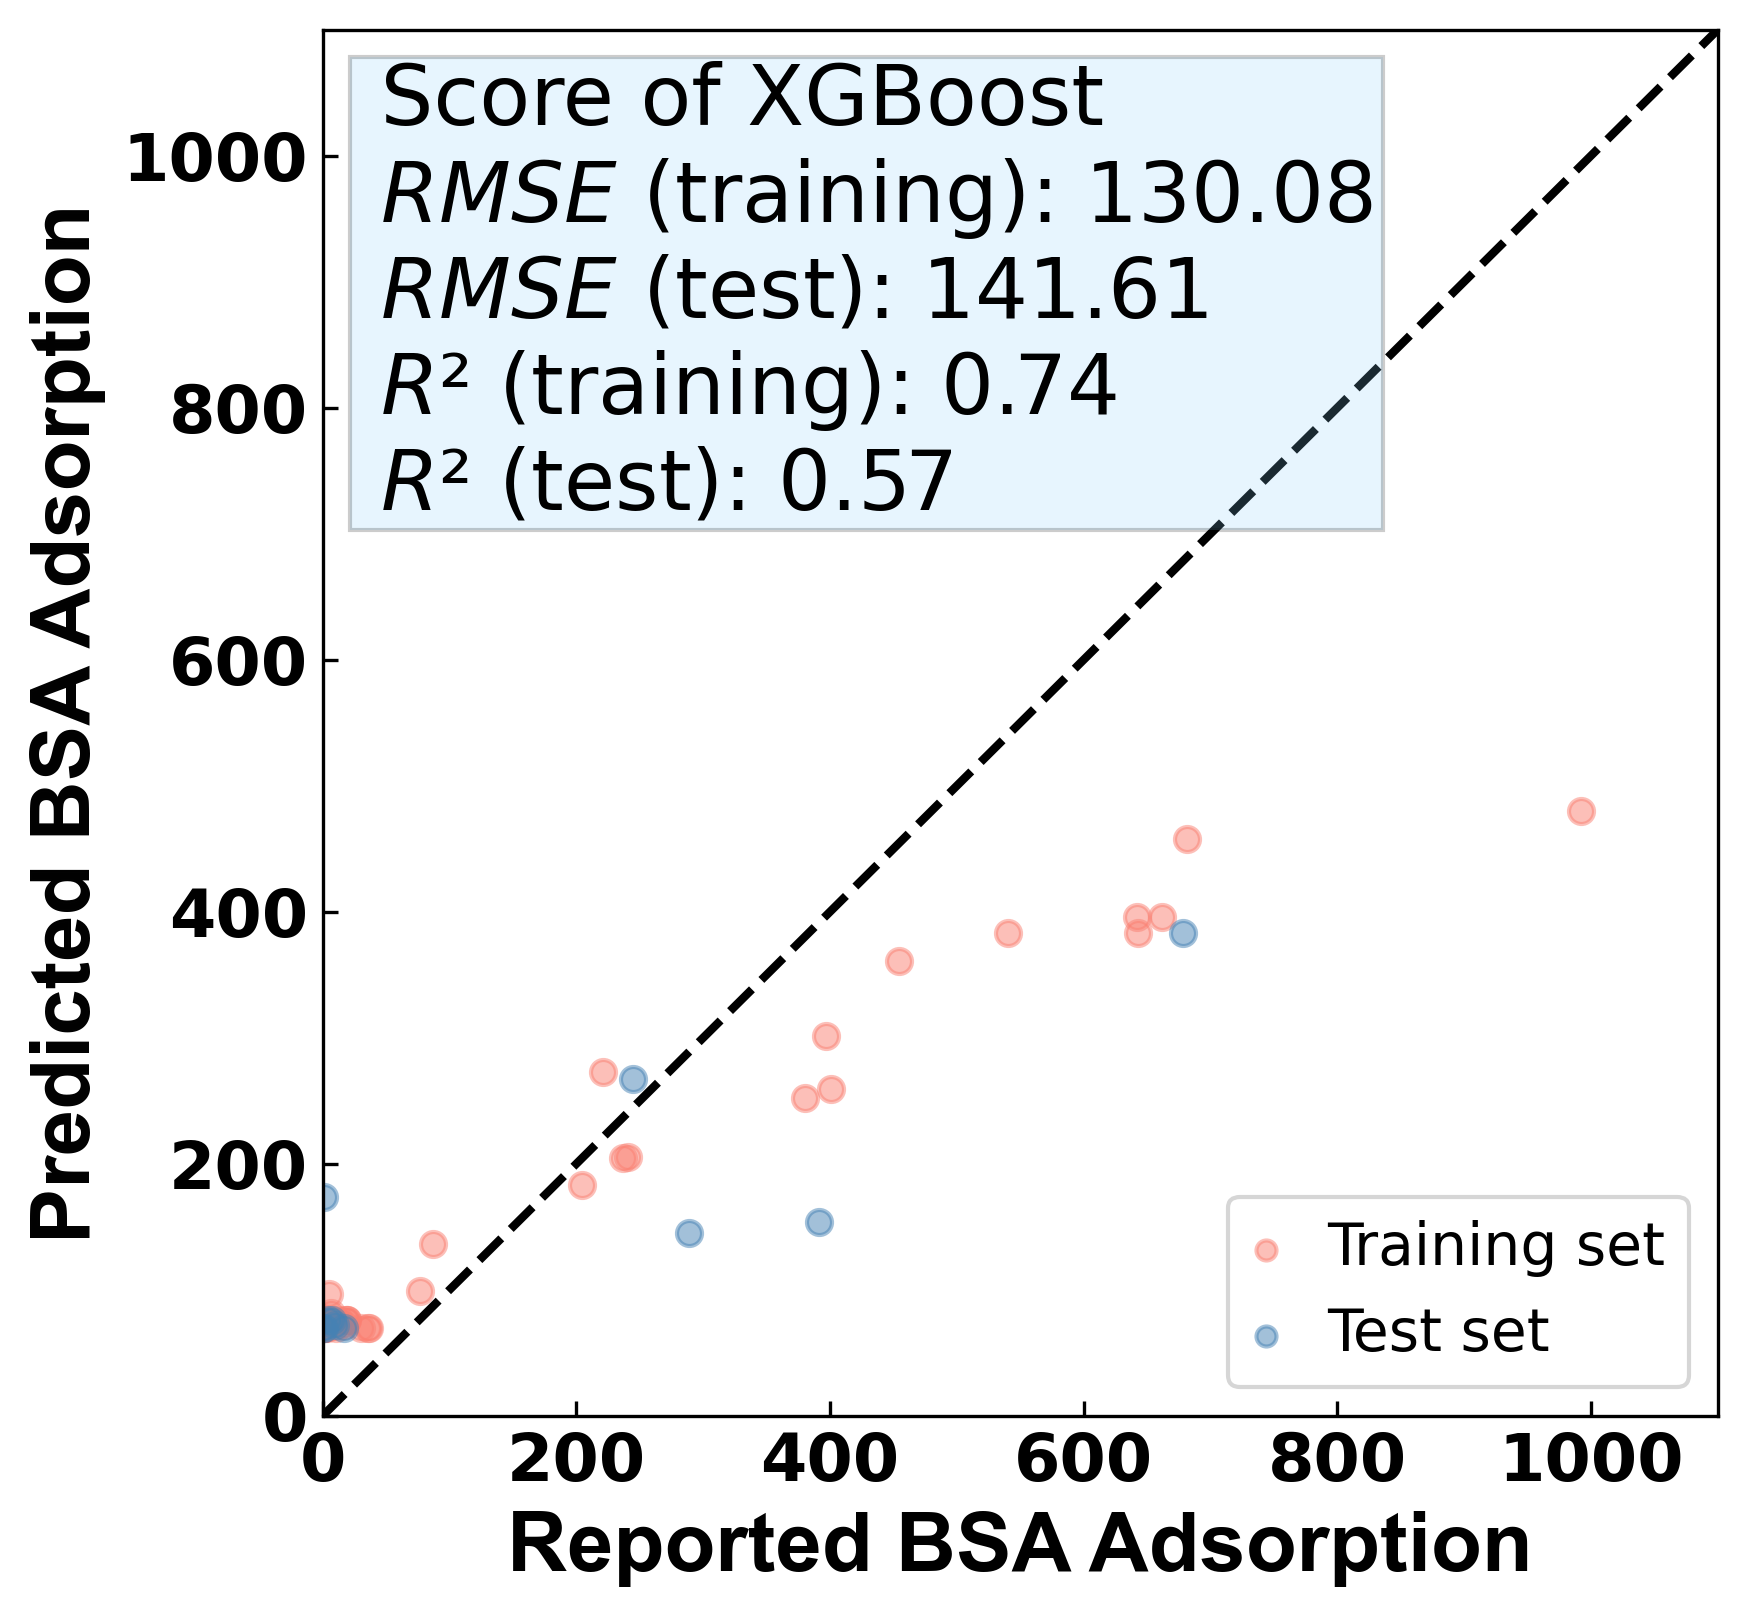

<Figure size 640x480 with 0 Axes>

In [12]:
models_name = ["LASSO", "Ridge", "Decision Tree", "Random Forest", "kNN", "SVR", "XGBoost"]

for i in range(len(trained_models_a)):
    result_show(trained_models_a[i], models_name[i], X_part_a, Y_part_array, X_val_a, Y_val_array)

model_output = "margin" has been renamed to model_output = "raw"
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


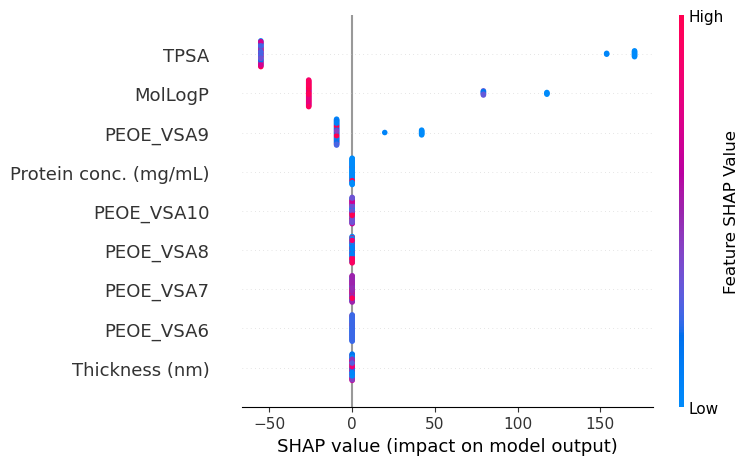

In [23]:
explainer = shap.TreeExplainer(model=trained_models_a[3],
                                feature_perturbation='tree_path_dependent',
                                model_output='margin')
shap_values = explainer.shap_values(X_part_a)
shap.summary_plot(shap_values, X_part_a, feature_names=df_a.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)

Predicted CA & Zeta

In [13]:
selected_b = ["Thickness (nm)", "Predicted Zeta (mV)", "Predicted CA (deg)",
              "Protein conc. (mg/mL)"]
df_b = df[selected_b]

df_b.head()

Thickness (nm)  Predicted Zeta (mV)  Predicted CA (deg)  \
0            13.8            16.319553           16.000903   
1            19.5             7.166369           65.901976   
2            10.3            -9.967725           74.526047   
3            15.2           -29.943920           82.069702   
4            20.2           -18.314512           42.474985   

   Protein conc. (mg/mL)  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0

In [14]:
scaler = MaxAbsScaler()
X_b = scaler.fit_transform(df_b)
X_b = np.array(X_b)

Y = np.array(df_label)

X_part_b, X_val_b, Y_part_array, Y_val_array = train_test_split(X_b, Y, test_size=0.2, random_state=42)


In [15]:
param_lasso = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_ridge = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_tree = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 10, 1),
             "random_state": [42]}

param_forest = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 5, 1),
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

param_knn = {"n_neighbors": np.arange(1, 15),
              "weights": ["uniform", "distance"]}

param_svr = {"C": [0.1, 1, 10, 100, 1000],
              "epsilon": [0.01, 0.1, 1, 10],
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}

param_xgb = {"max_depth": np.arange(1, 20),
             "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

models_param = {
    "Lasso": {"model": Lasso(), "param": param_lasso},
    "Ridge": {"model": Ridge(), "param": param_ridge},
    "Decision Tree": {"model": DecisionTreeRegressor(), "param": param_tree},
    "Random Forest": {"model": RandomForestRegressor(), "param": param_forest},
    "kNN": {"model": KNeighborsRegressor(), "param": param_knn},
    "SVR": {"model": SVR(), "param": param_svr},
    "XGBoost": {"model": XGBRegressor(), "param": param_xgb}
}

optimized_models = {"Lasso":{"scores":[]},
                    "Ridge":{"scores":[]},
                    "Decision Tree":{"scores":[]},
                    "Random Forest":{"scores":[]},
                    "kNN":{"scores":[]},
                    "SVR":{"scores":[]},
                    "XGBoost":{"scores":[]}}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
loo = LeaveOneOut()

In [16]:
trained_models_b = []

for model_name, model_param in models_param.items():
    print("Training "+model_name+"...")
    model = model_param["model"]
    param = model_param["param"]
    
    grid = GridSearchCV(model, param, cv=outer_cv, n_jobs=-1)
    grid.fit(X_part_b, Y_part_array)
    #grid_models_peoe.append(grid)
    print("Best parameters for "+model_name, grid.best_params_)
    model_ = grid.best_estimator_
    # dump(model_peoe, model_name+"_peoe.joblib")
    trained_models_b.append(model_)

    print("-------------------------NEXT-------------------------")

Training Lasso...
Best parameters for Lasso {'alpha': 2.99, 'fit_intercept': True}
-------------------------NEXT-------------------------
Training Ridge...
Best parameters for Ridge {'alpha': 2.99, 'fit_intercept': False}
-------------------------NEXT-------------------------
Training Decision Tree...
Best parameters for Decision Tree {'max_depth': 2, 'min_samples_leaf': 1, 'random_state': 42}
-------------------------NEXT-------------------------
Training Random Forest...
Best parameters for Random Forest {'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 125, 'random_state': 42}
-------------------------NEXT-------------------------
Training kNN...
Best parameters for kNN {'n_neighbors': 13, 'weights': 'distance'}
-------------------------NEXT-------------------------
Training SVR...
Best parameters for SVR {'C': 1000, 'epsilon': 0.01, 'kernel': 'rbf'}
-------------------------NEXT-------------------------
Training XGBoost...
Best parameters for XGBoost {'learning_rate': 0.01, '

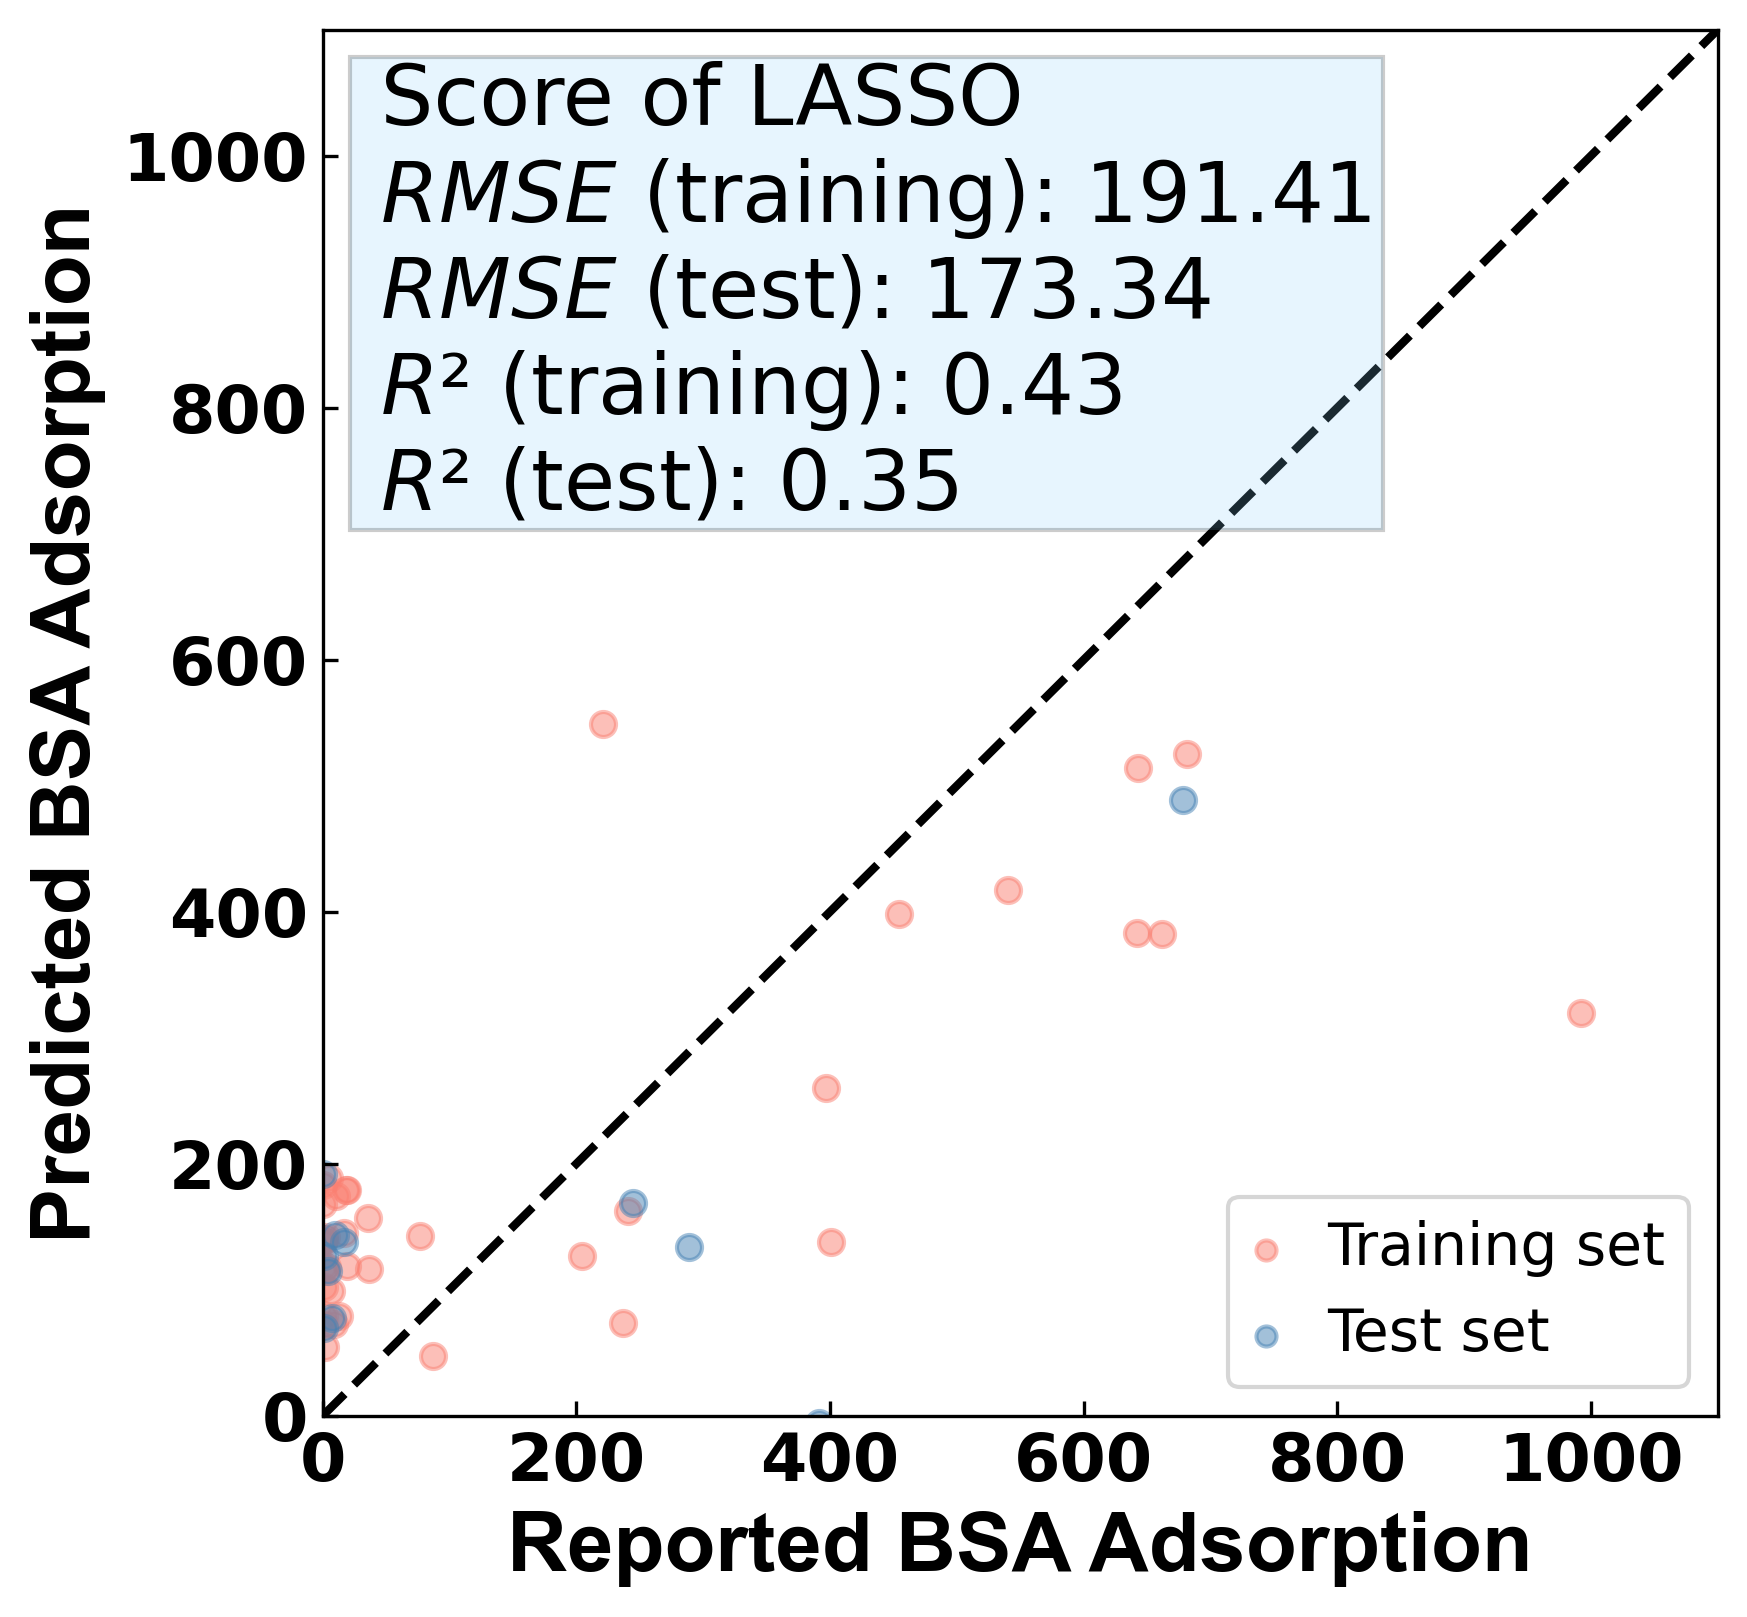

<Figure size 640x480 with 0 Axes>

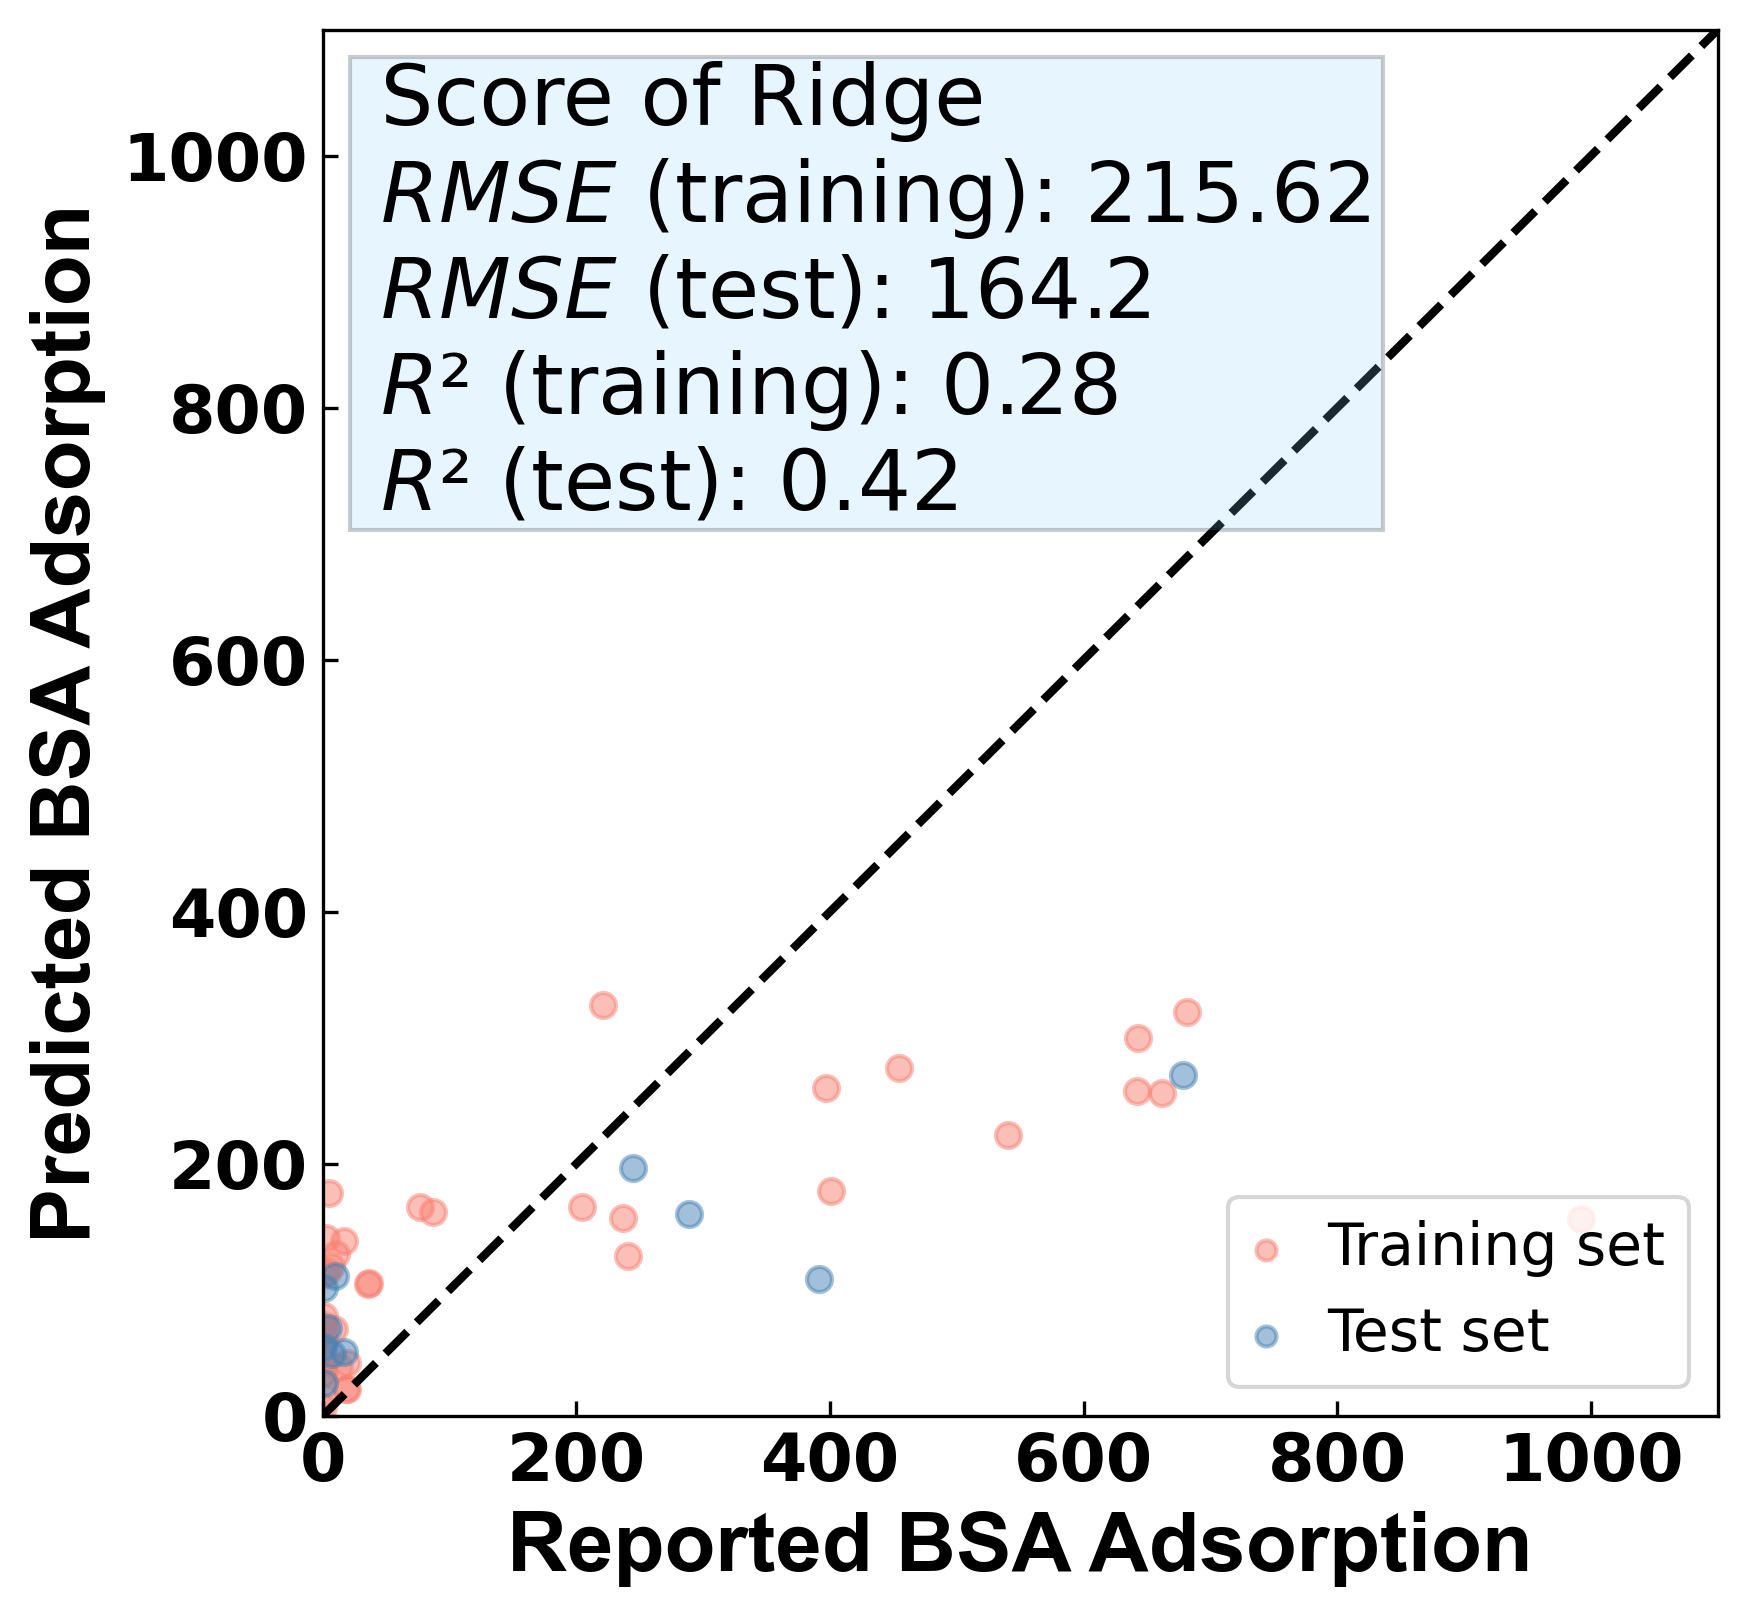

<Figure size 640x480 with 0 Axes>

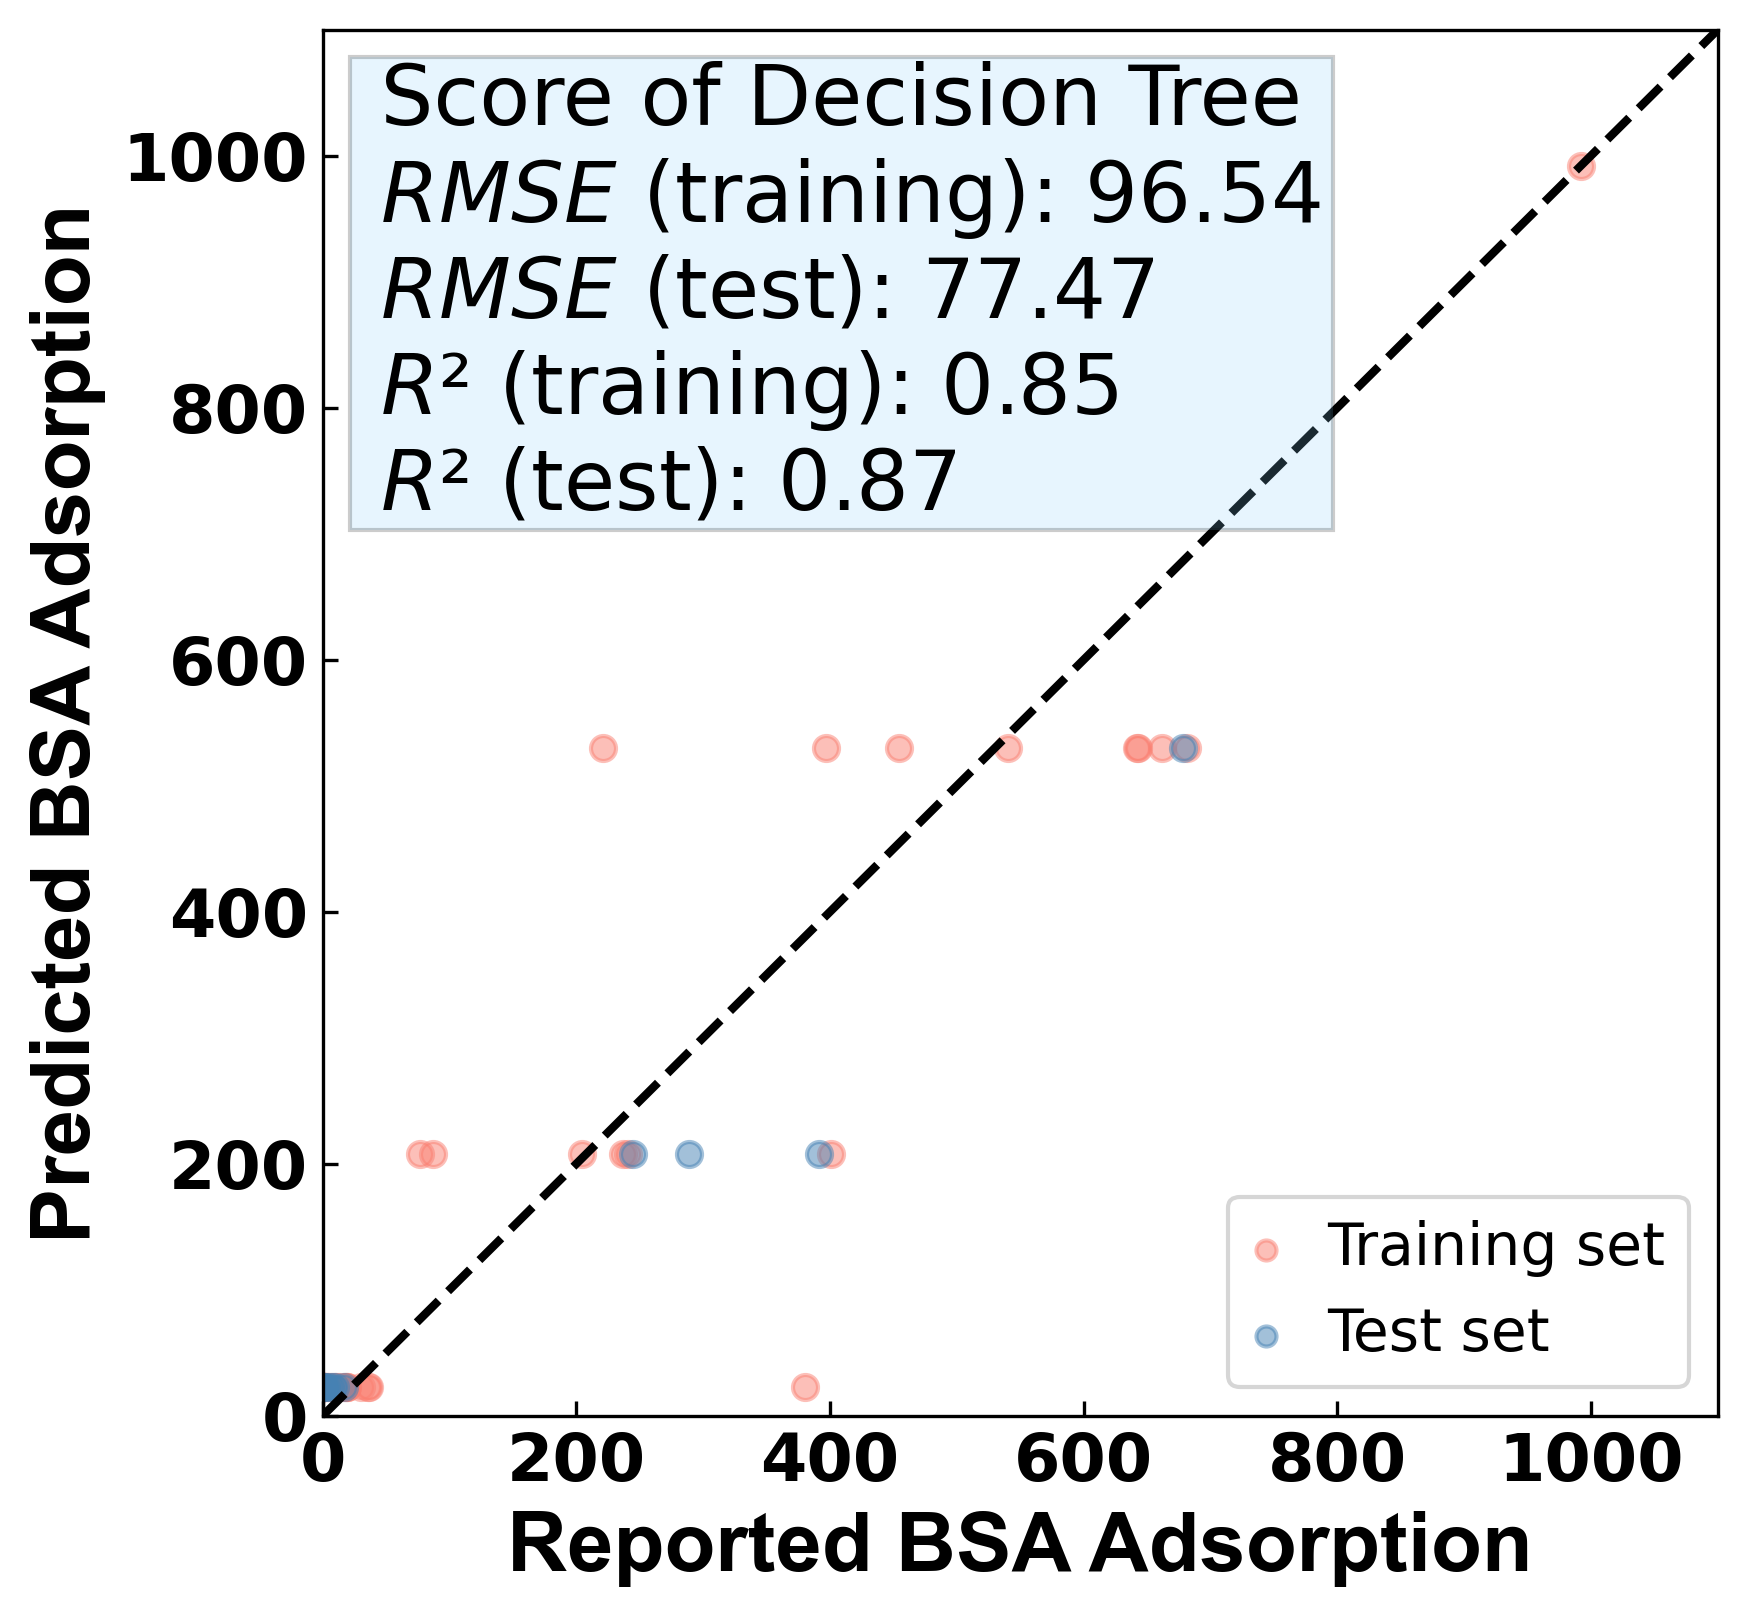

<Figure size 640x480 with 0 Axes>

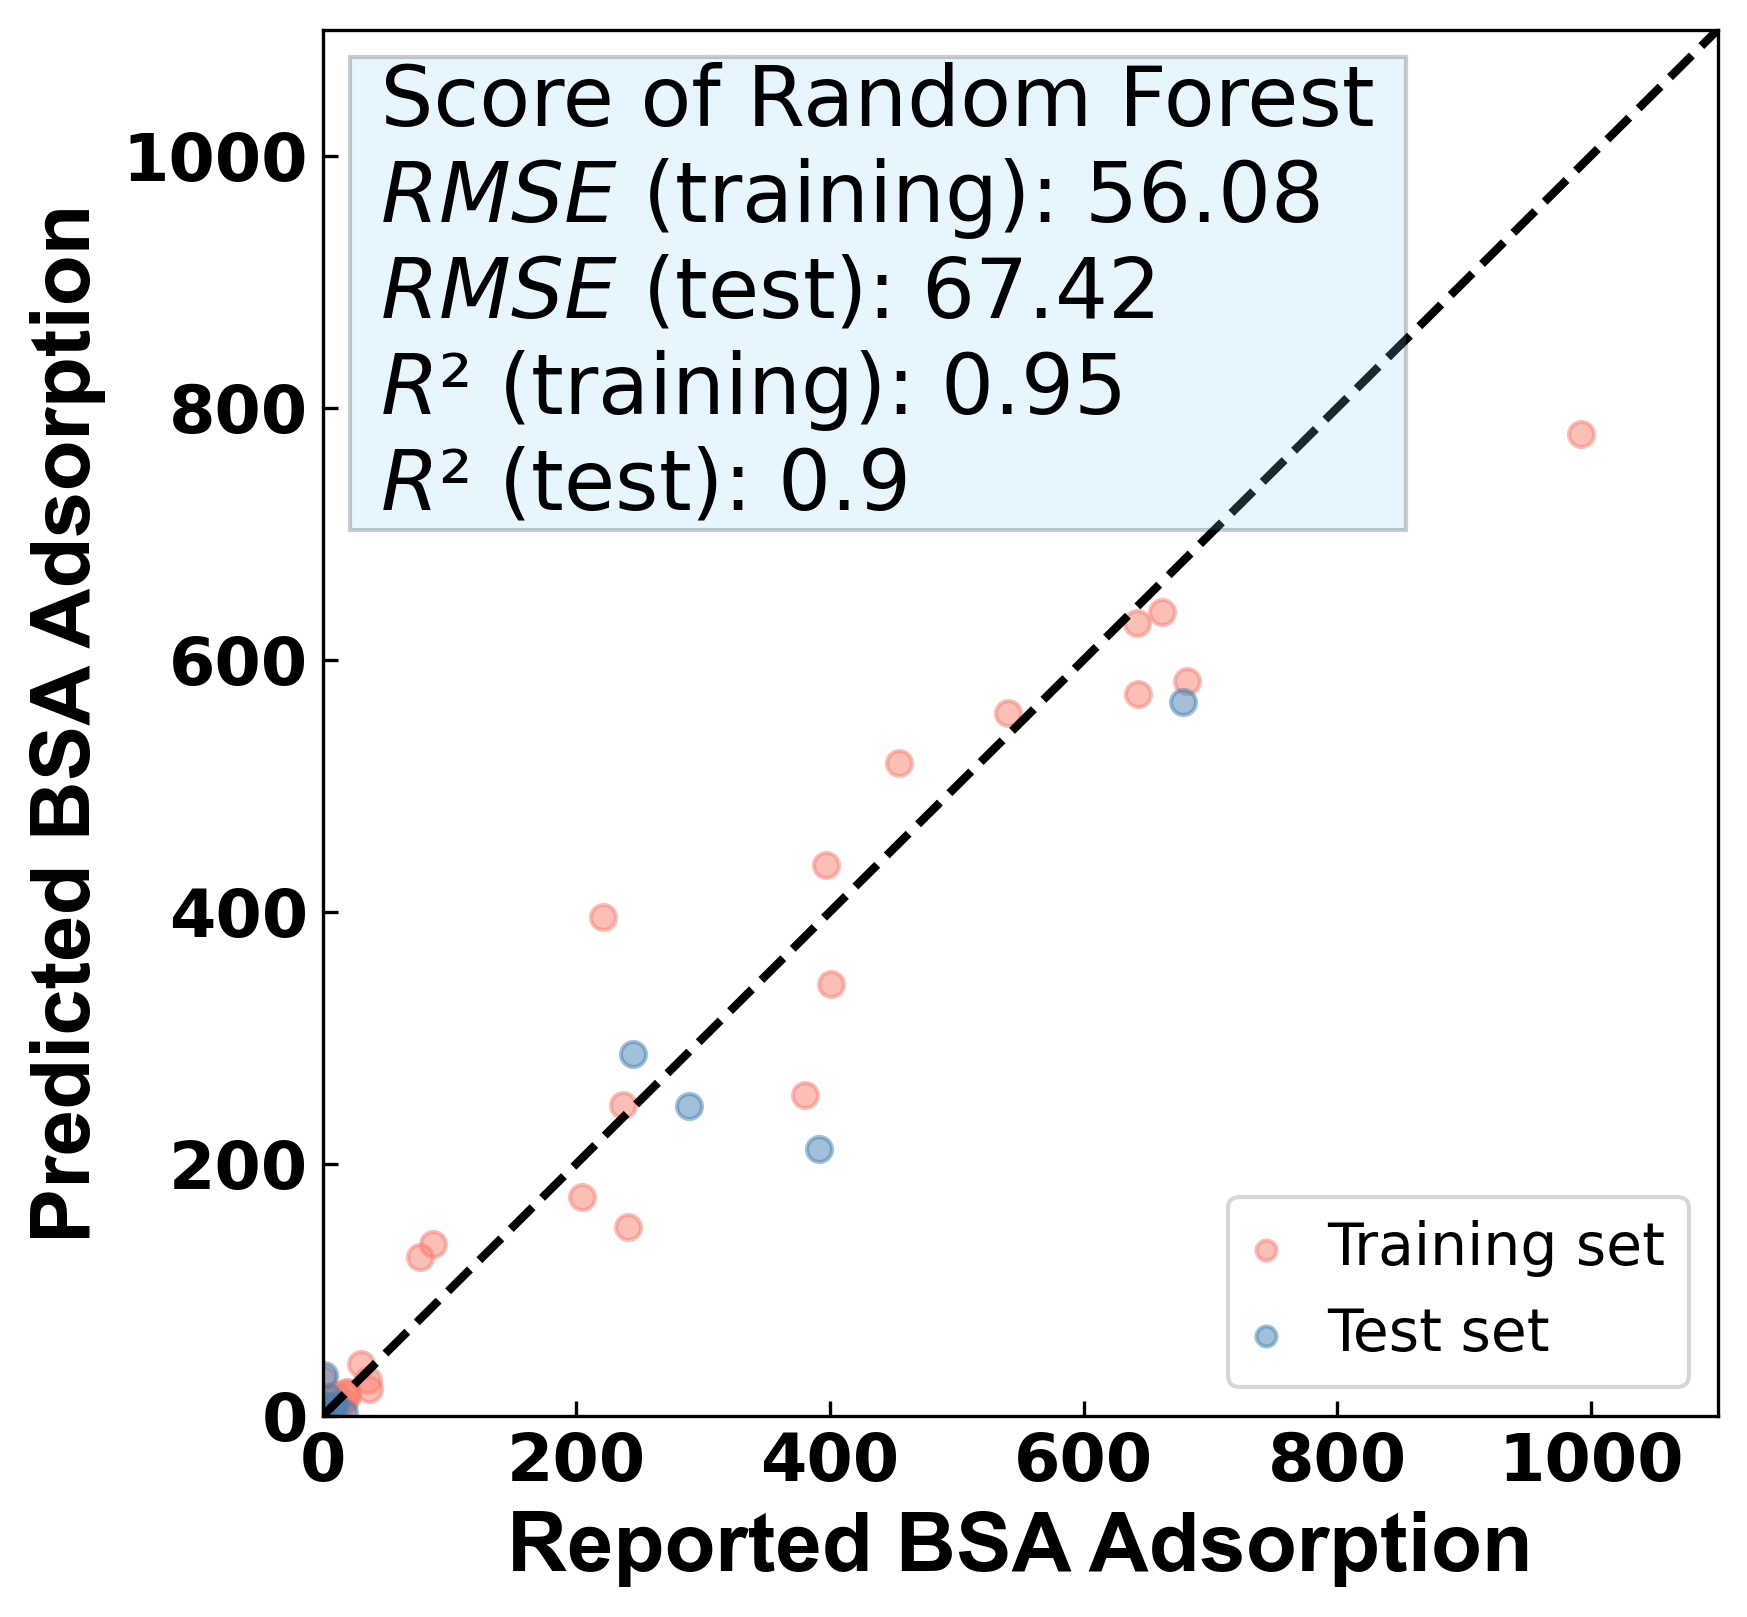

<Figure size 640x480 with 0 Axes>

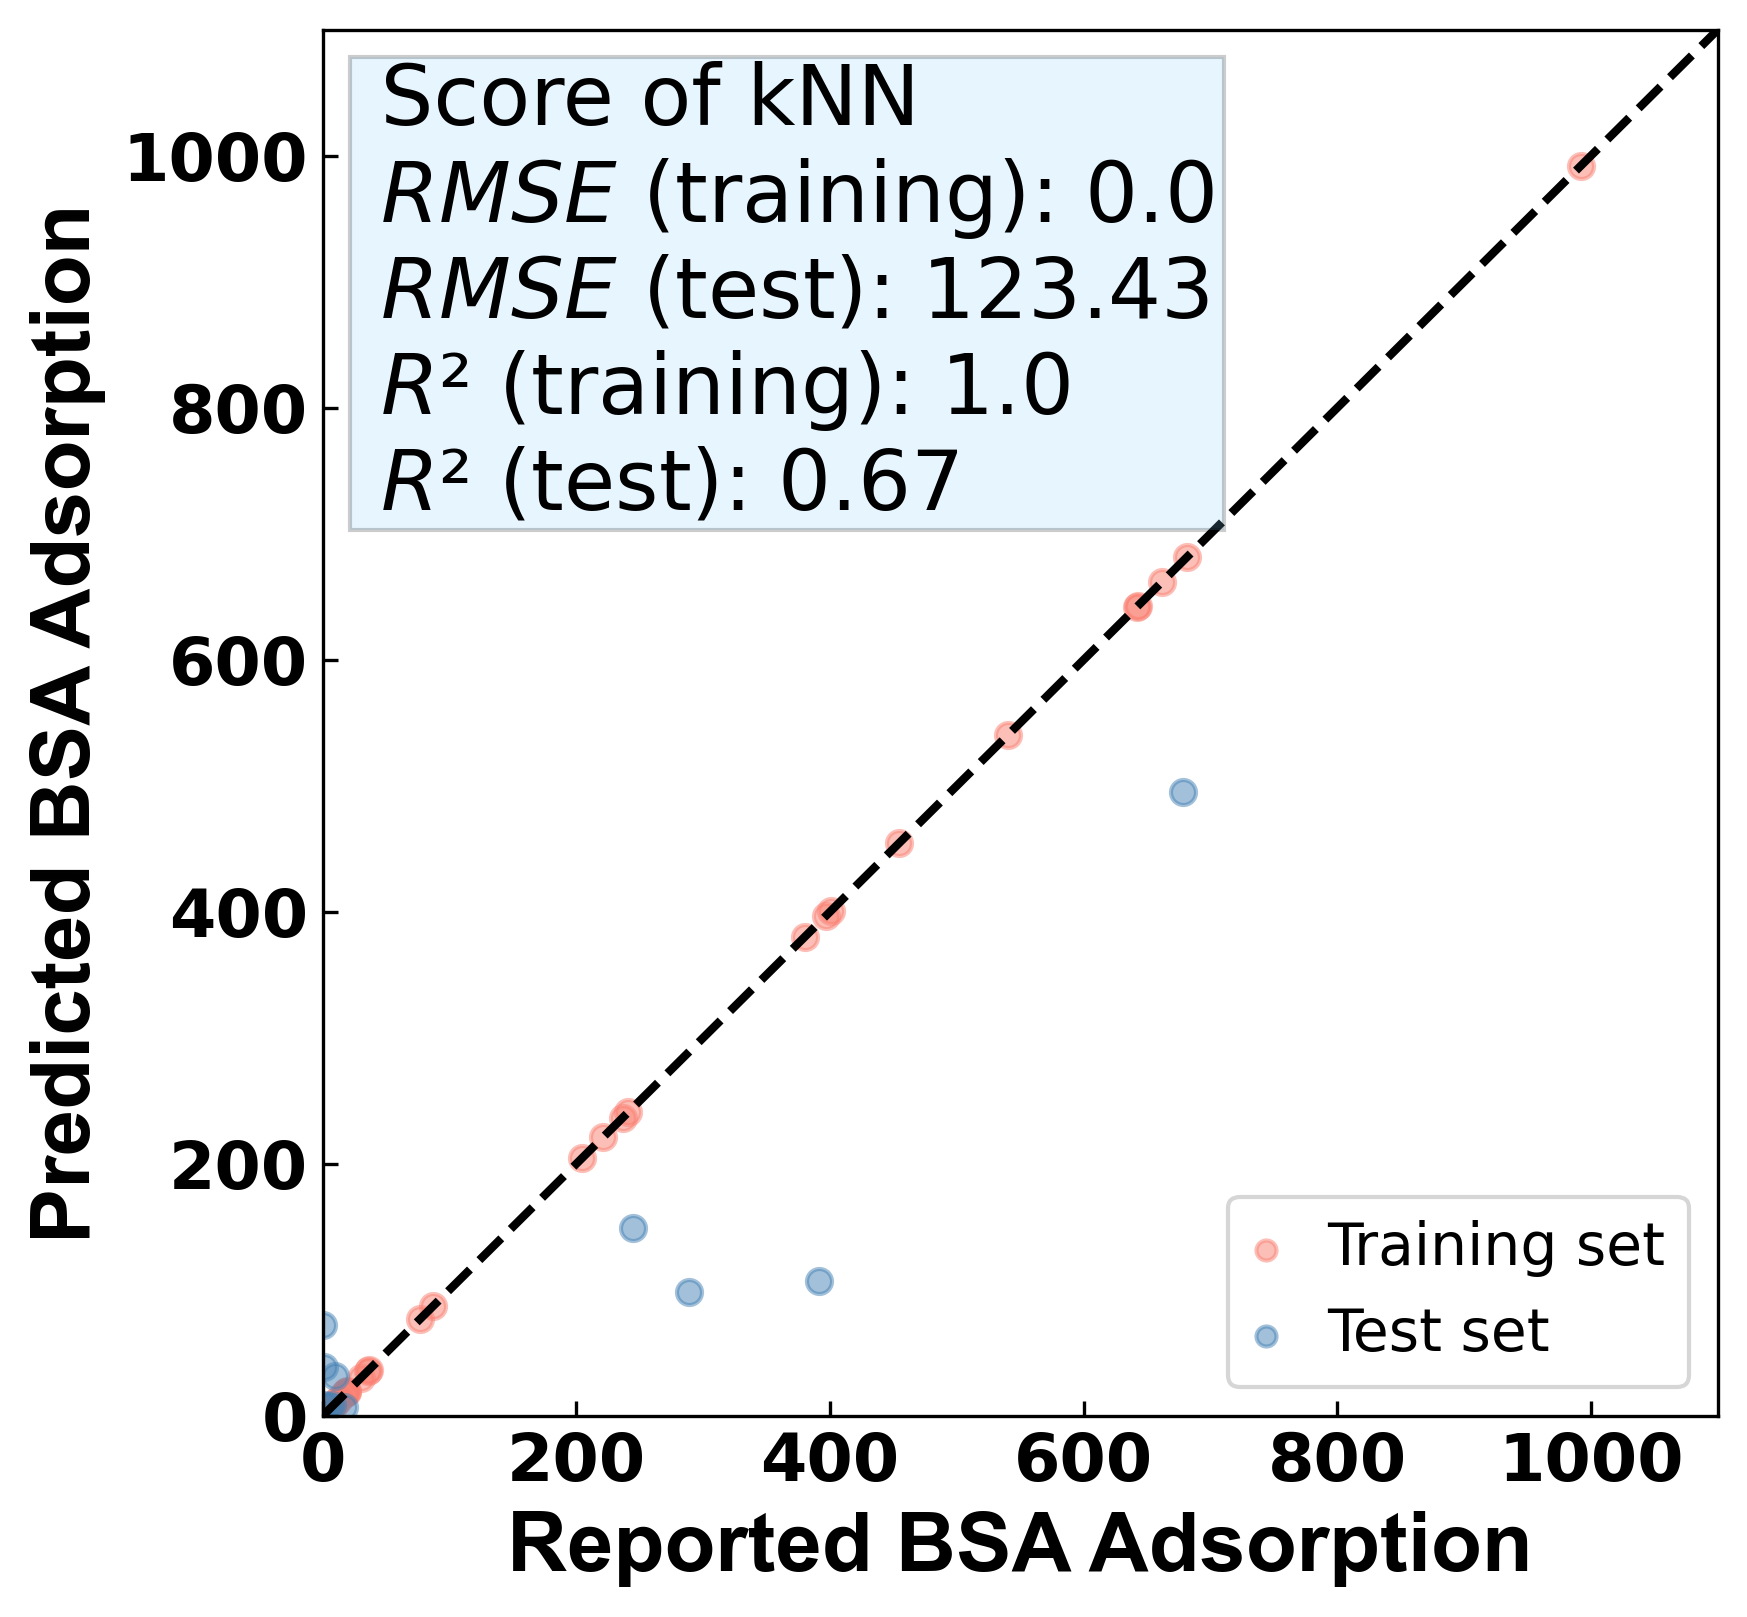

<Figure size 640x480 with 0 Axes>

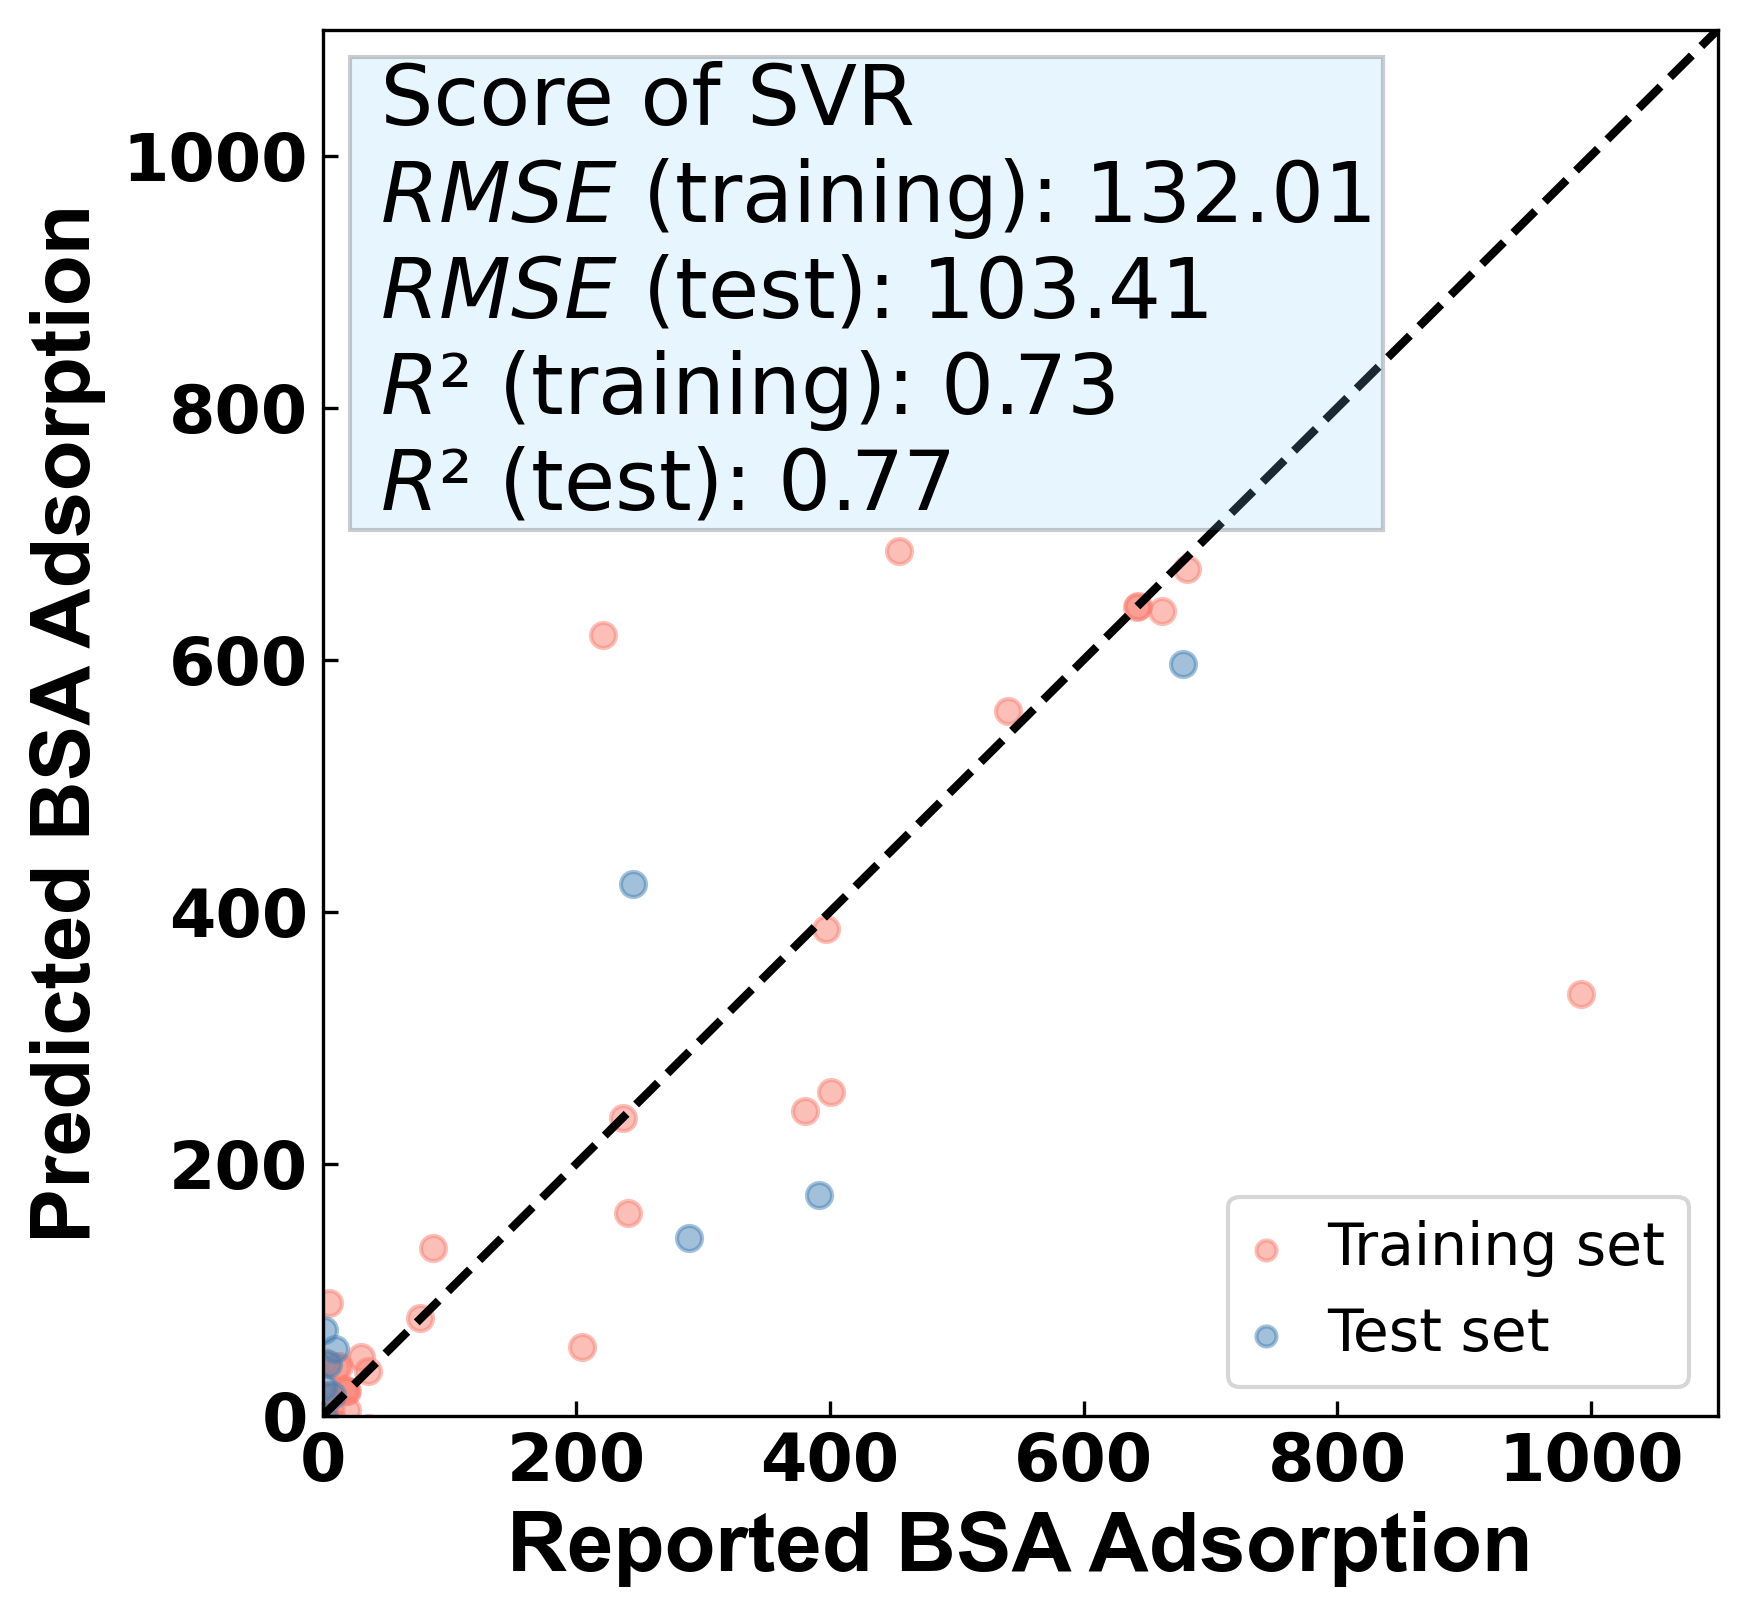

<Figure size 640x480 with 0 Axes>

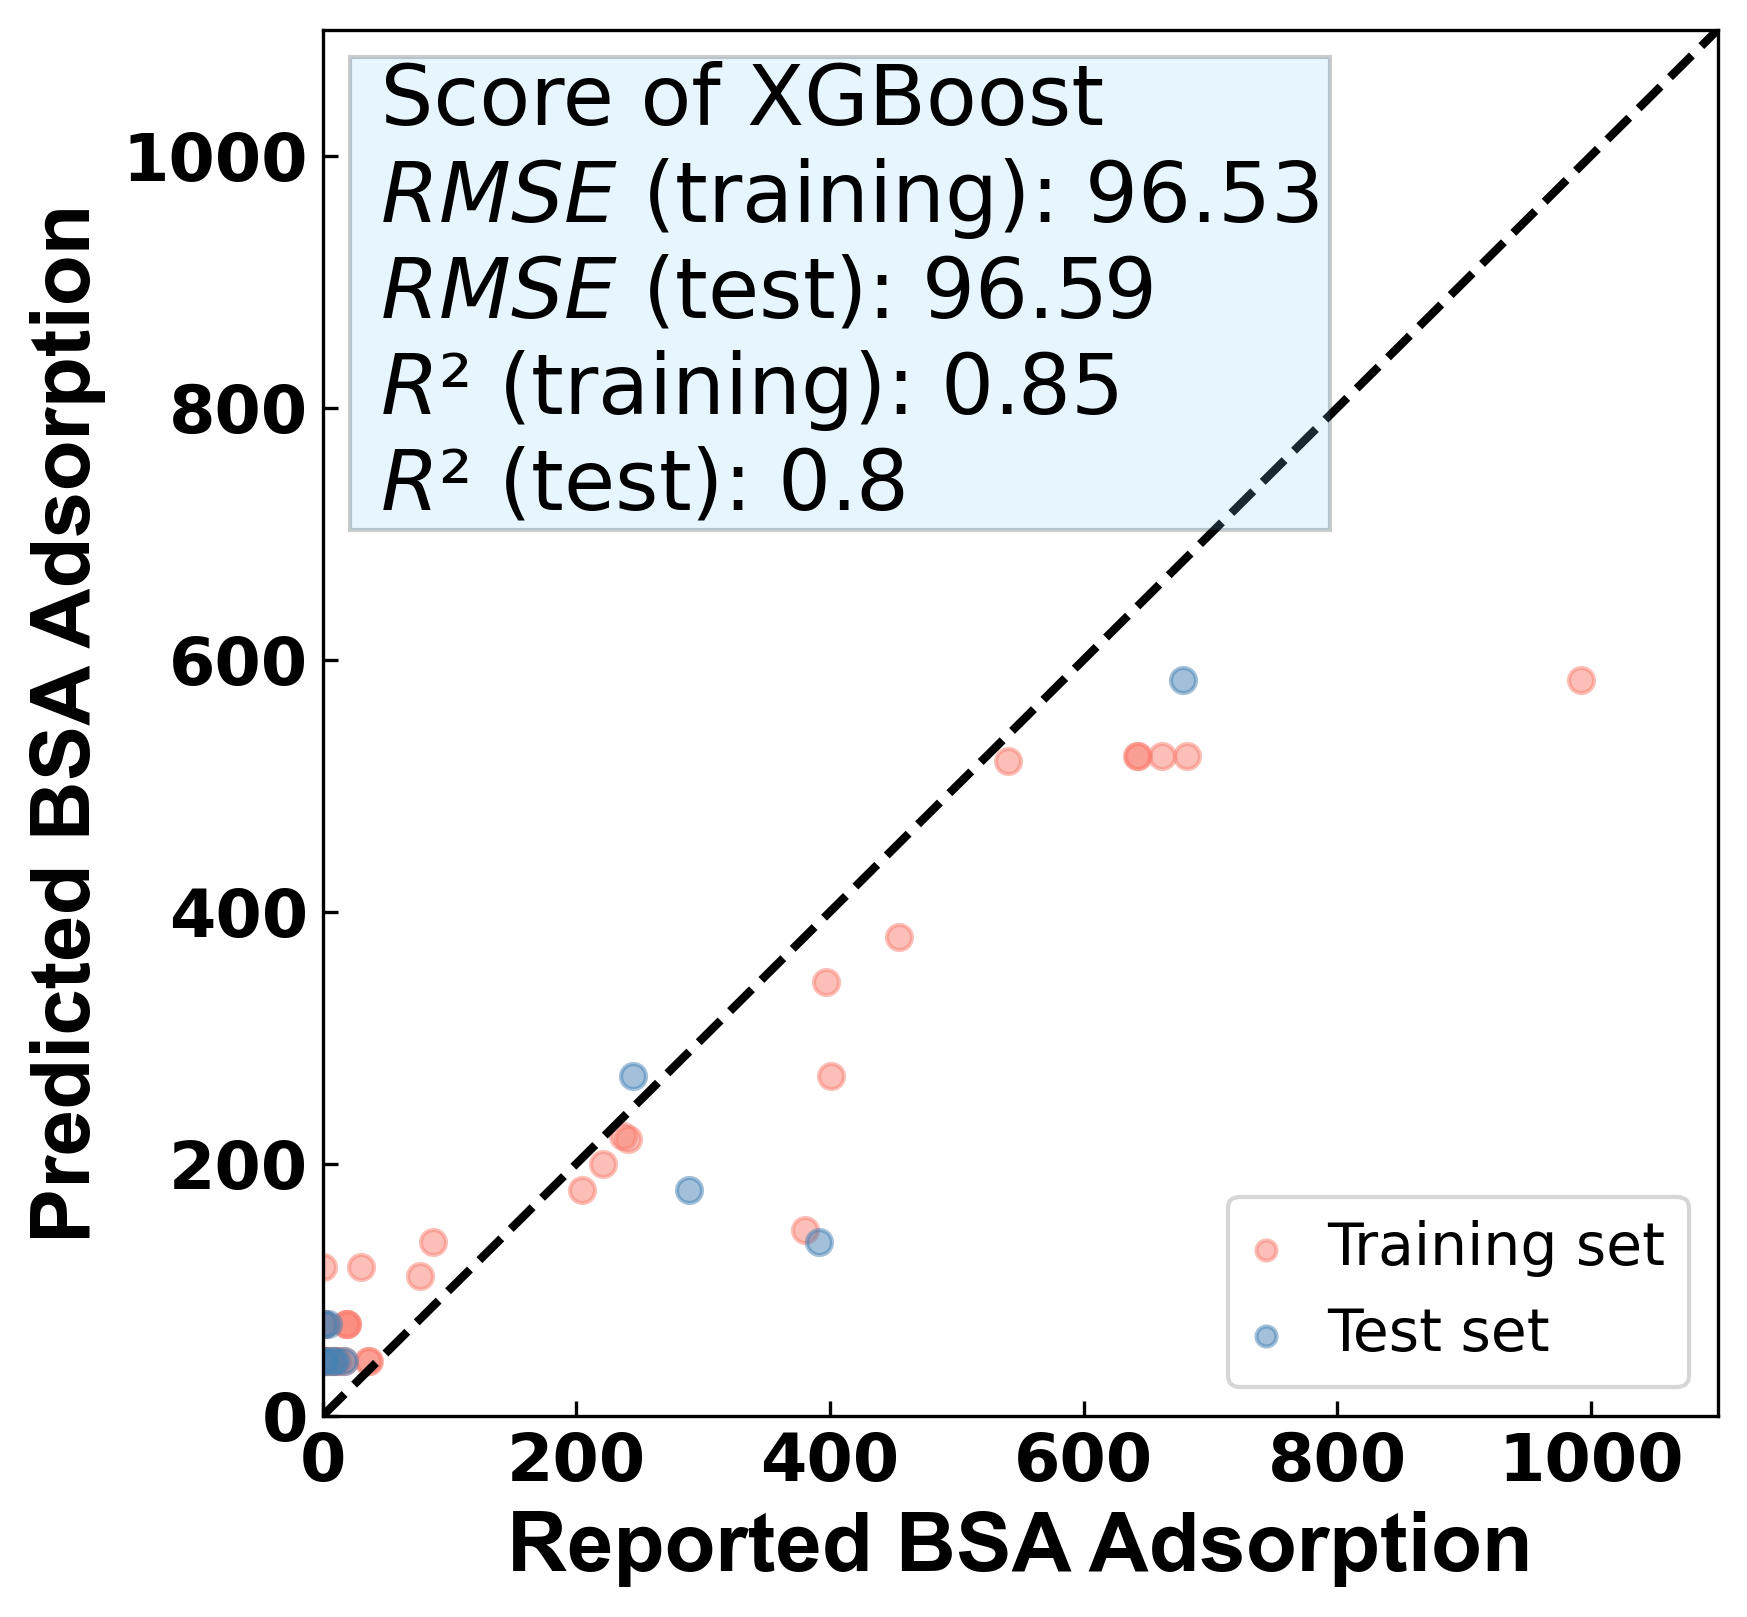

<Figure size 640x480 with 0 Axes>

In [17]:
models_name = ["LASSO", "Ridge", "Decision Tree", "Random Forest", "kNN", "SVR", "XGBoost"]

for i in range(len(trained_models_b)):
    result_show(trained_models_b[i], models_name[i], X_part_b, Y_part_array, X_val_b, Y_val_array)

model_output = "margin" has been renamed to model_output = "raw"
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


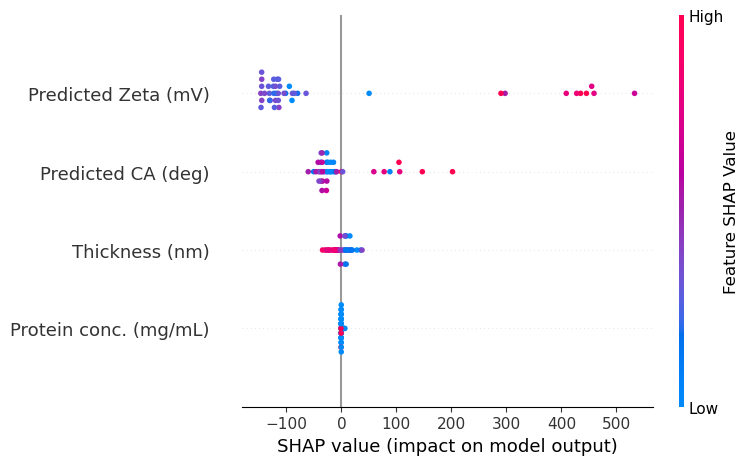

In [24]:
explainer = shap.TreeExplainer(model=trained_models_b[3],
                                feature_perturbation='tree_path_dependent',
                                model_output='margin')
shap_values = explainer.shap_values(X_part_b)
shap.summary_plot(shap_values, X_part_b, feature_names=df_b.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)

A+B

In [18]:

selected_c = ["Thickness (nm)",
              "MolLogP", "TPSA",
              "PEOE_VSA6", "PEOE_VSA7", "PEOE_VSA8", "PEOE_VSA9", "PEOE_VSA10", 
              "Predicted Zeta (mV)", "Predicted CA (deg)",
              "Protein conc. (mg/mL)"]
df_c = df[selected_c]

df_c.head()

Thickness (nm)  MolLogP    TPSA  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  \
0            13.8   0.6673   29.54   6.578936  21.019081  12.117861   
1            19.5   0.0000    0.00   0.000000   6.578936  34.618686   
2            10.3   1.1256   26.30   6.578936  13.847474   5.573105   
3            15.2   1.5141   26.30   6.578936  20.771212   5.573105   
4            20.2   0.8849  109.37   6.578936   6.923737  12.682902   

    PEOE_VSA9  PEOE_VSA10  Predicted Zeta (mV)  Predicted CA (deg)  \
0    0.000000    6.606882            16.319553           16.000903   
1    5.573105   17.143896             7.166369           65.901976   
2    6.606882    0.000000            -9.967725           74.526047   
3    6.103966    0.000000           -29.943920           82.069702   
4  112.316993    6.606882           -18.314512           42.474985   

   Protein conc. (mg/mL)  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0

In [19]:
scaler = MaxAbsScaler()
X_c = scaler.fit_transform(df_c)
X_c = np.array(X_c)

Y = np.array(df_label)

X_part_c, X_val_c, Y_part_array, Y_val_array = train_test_split(X_c, Y, test_size=0.2, random_state=42)

In [20]:
param_lasso = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_ridge = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_tree = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 10, 1),
             "random_state": [42]}

param_forest = {"max_depth": np.arange(1, 10),
             "min_samples_leaf": np.arange(1, 5, 1),
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

param_knn = {"n_neighbors": np.arange(1, 15),
              "weights": ["uniform", "distance"]}

param_svr = {"C": [0.1, 1, 10, 100, 1000],
              "epsilon": [0.01, 0.1, 1, 10],
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}

param_xgb = {"max_depth": np.arange(1, 20),
             "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
             "n_estimators": [50, 75, 100, 125, 150, 250, 500],
             "random_state": [42]}

models_param = {
    "Lasso": {"model": Lasso(), "param": param_lasso},
    "Ridge": {"model": Ridge(), "param": param_ridge},
    "Decision Tree": {"model": DecisionTreeRegressor(), "param": param_tree},
    "Random Forest": {"model": RandomForestRegressor(), "param": param_forest},
    "kNN": {"model": KNeighborsRegressor(), "param": param_knn},
    "SVR": {"model": SVR(), "param": param_svr},
    "XGBoost": {"model": XGBRegressor(), "param": param_xgb}
}

optimized_models = {"Lasso":{"scores":[]},
                    "Ridge":{"scores":[]},
                    "Decision Tree":{"scores":[]},
                    "Random Forest":{"scores":[]},
                    "kNN":{"scores":[]},
                    "SVR":{"scores":[]},
                    "XGBoost":{"scores":[]}}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
loo = LeaveOneOut()

In [21]:
trained_models_c = []

for model_name, model_param in models_param.items():
    print("Training "+model_name+"...")
    model = model_param["model"]
    param = model_param["param"]
    
    grid = GridSearchCV(model, param, cv=outer_cv, n_jobs=-1)
    grid.fit(X_part_c, Y_part_array)
    #grid_models_peoe.append(grid)
    print("Best parameters for "+model_name, grid.best_params_)
    model_ = grid.best_estimator_
    # dump(model_peoe, model_name+"_peoe.joblib")
    trained_models_c.append(model_)

    print("-------------------------NEXT-------------------------")

Training Lasso...
Best parameters for Lasso {'alpha': 2.6500000000000004, 'fit_intercept': False}
-------------------------NEXT-------------------------
Training Ridge...
Best parameters for Ridge {'alpha': 2.64, 'fit_intercept': False}
-------------------------NEXT-------------------------
Training Decision Tree...
Best parameters for Decision Tree {'max_depth': 1, 'min_samples_leaf': 1, 'random_state': 42}
-------------------------NEXT-------------------------
Training Random Forest...
Best parameters for Random Forest {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 50, 'random_state': 42}
-------------------------NEXT-------------------------
Training kNN...
Best parameters for kNN {'n_neighbors': 14, 'weights': 'distance'}
-------------------------NEXT-------------------------
Training SVR...
Best parameters for SVR {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
-------------------------NEXT-------------------------
Training XGBoost...
Best parameters for XGBoost {'learning_ra

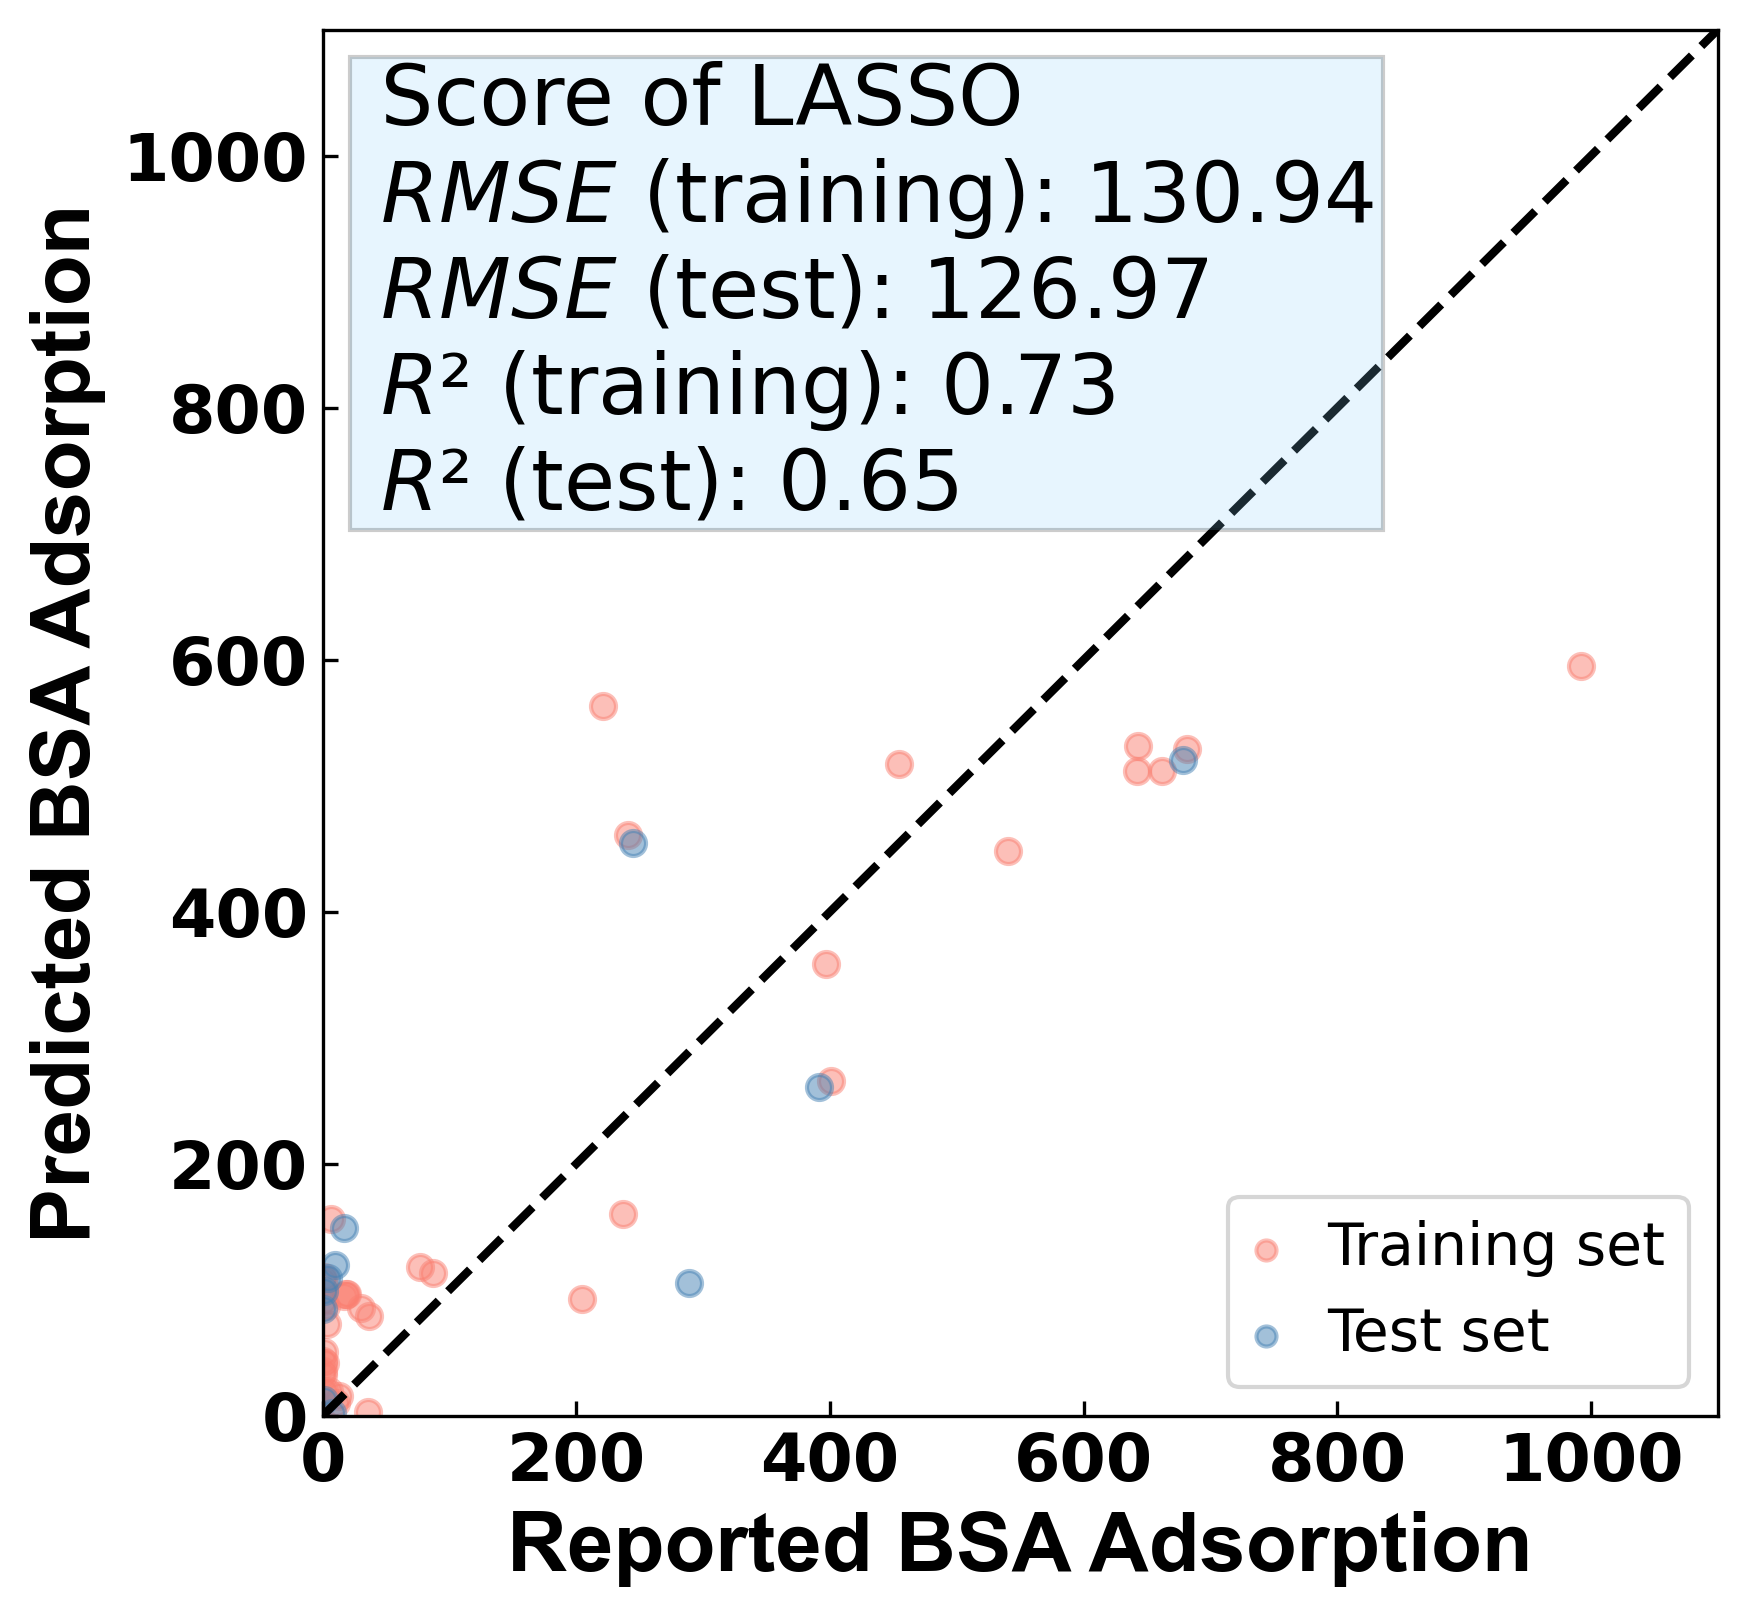

<Figure size 640x480 with 0 Axes>

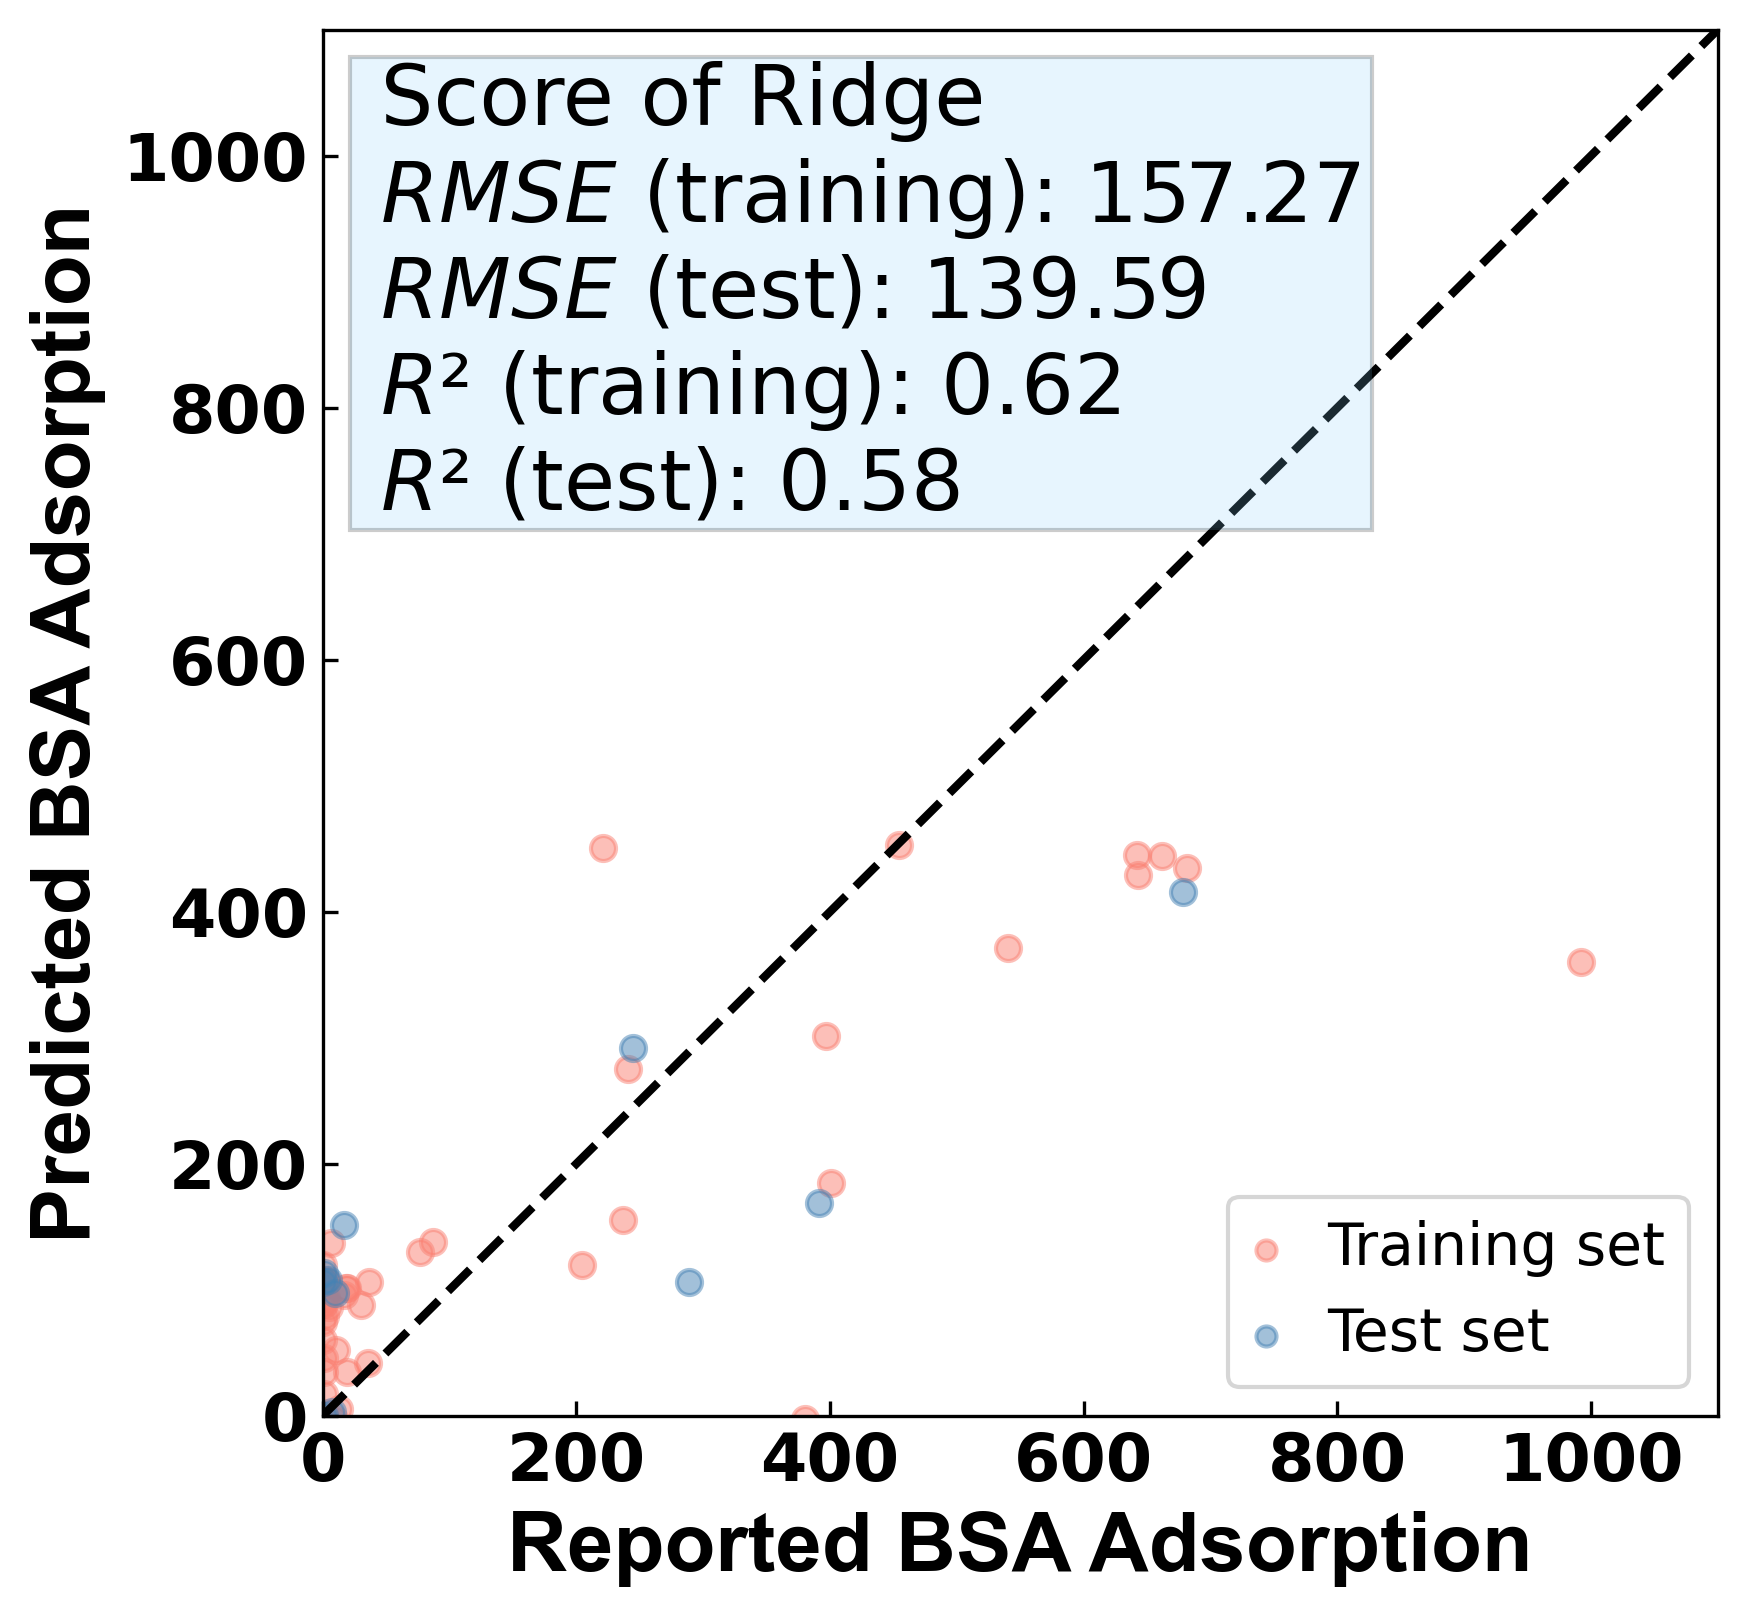

<Figure size 640x480 with 0 Axes>

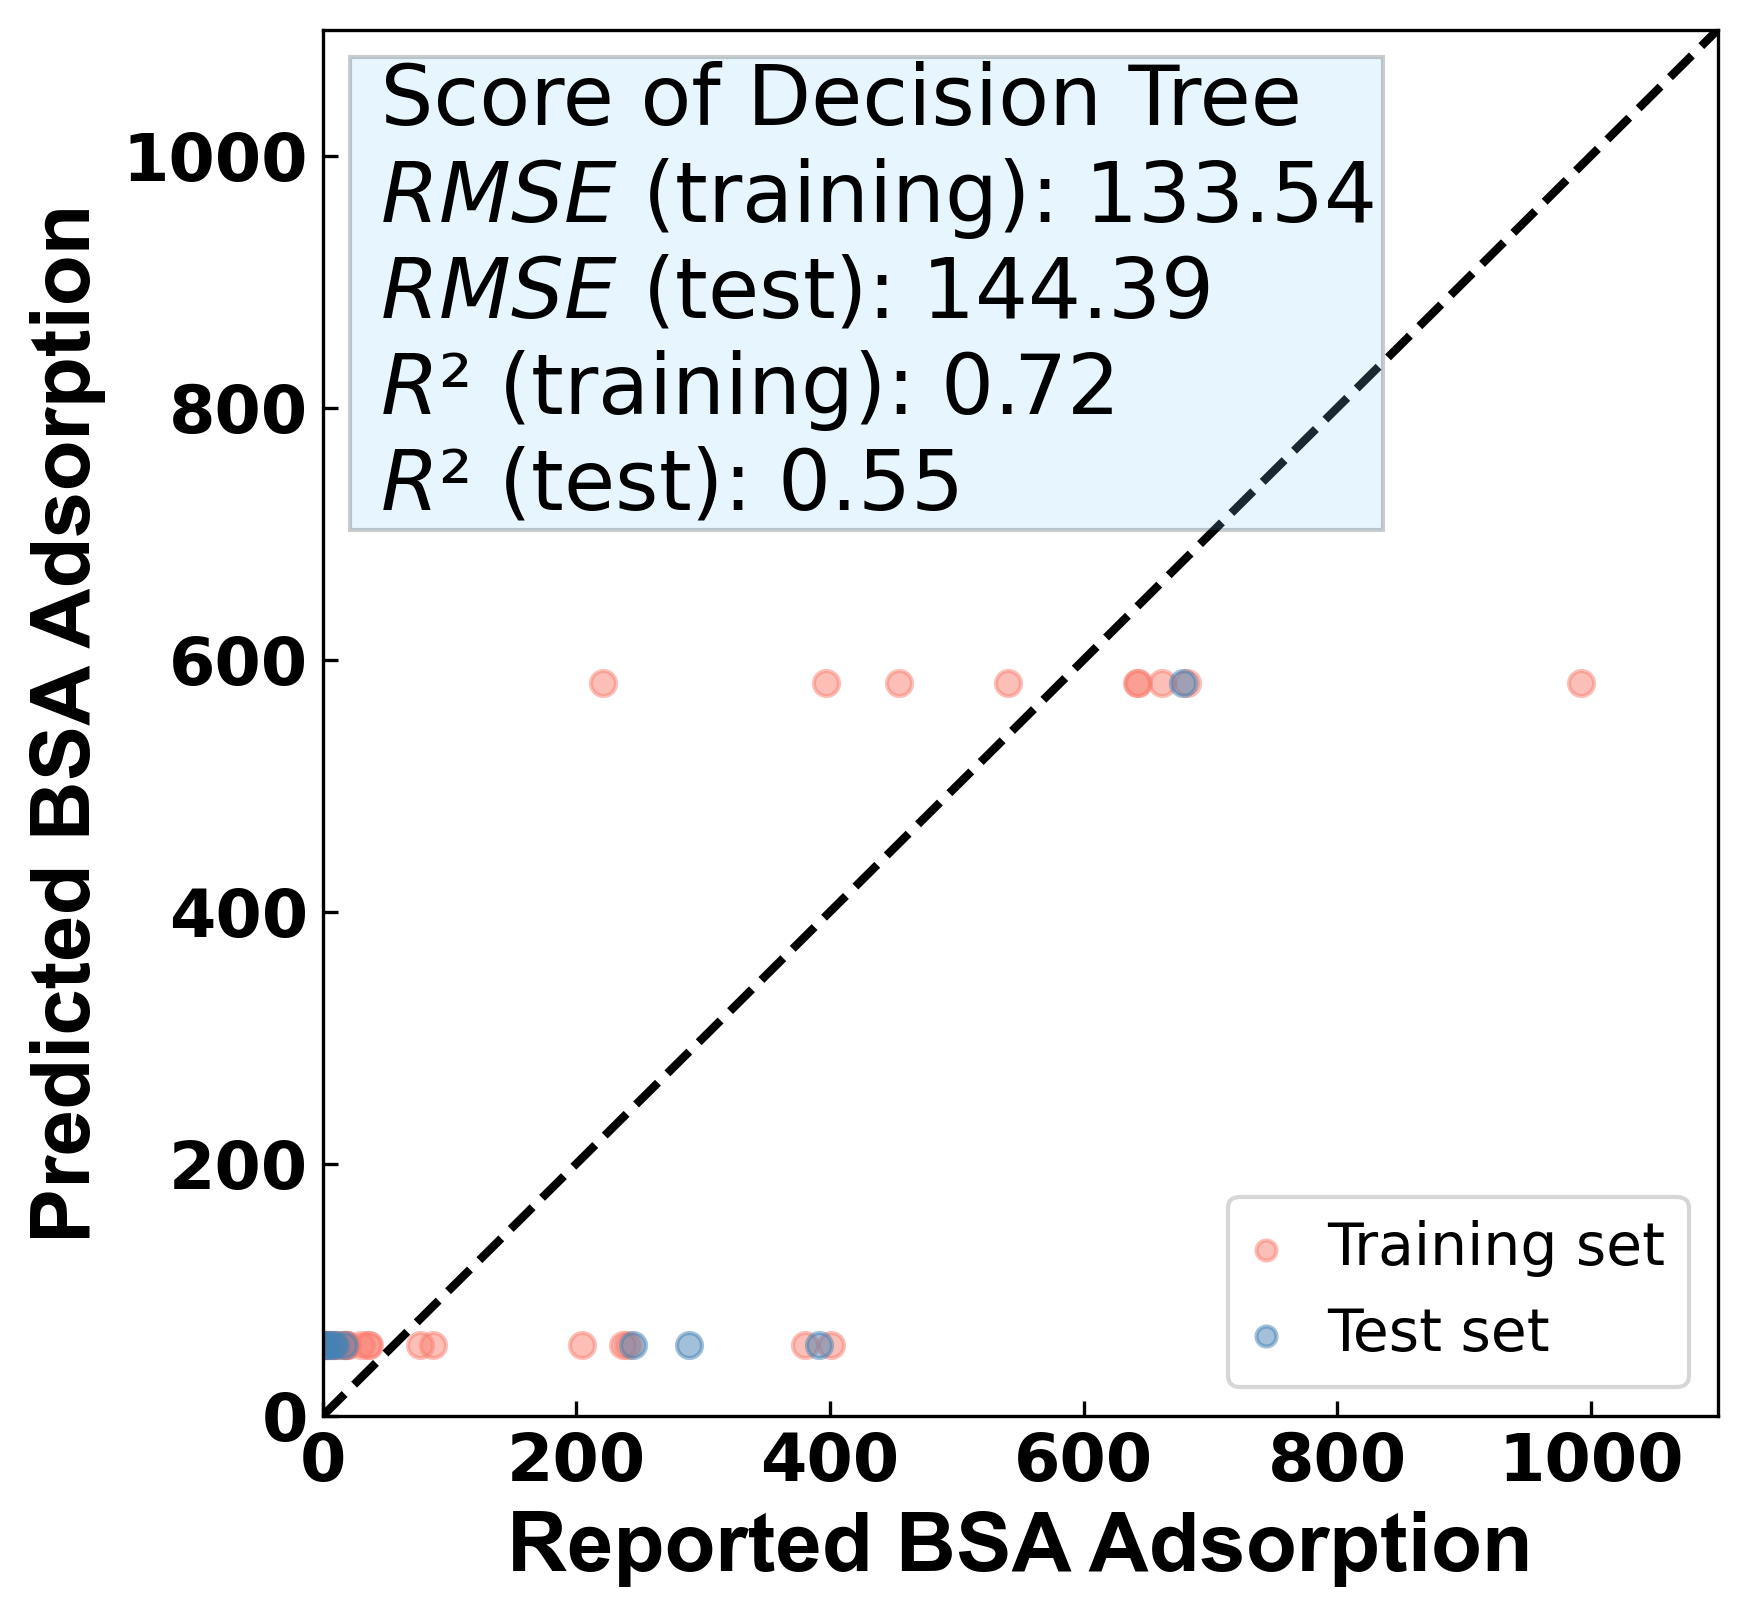

<Figure size 640x480 with 0 Axes>

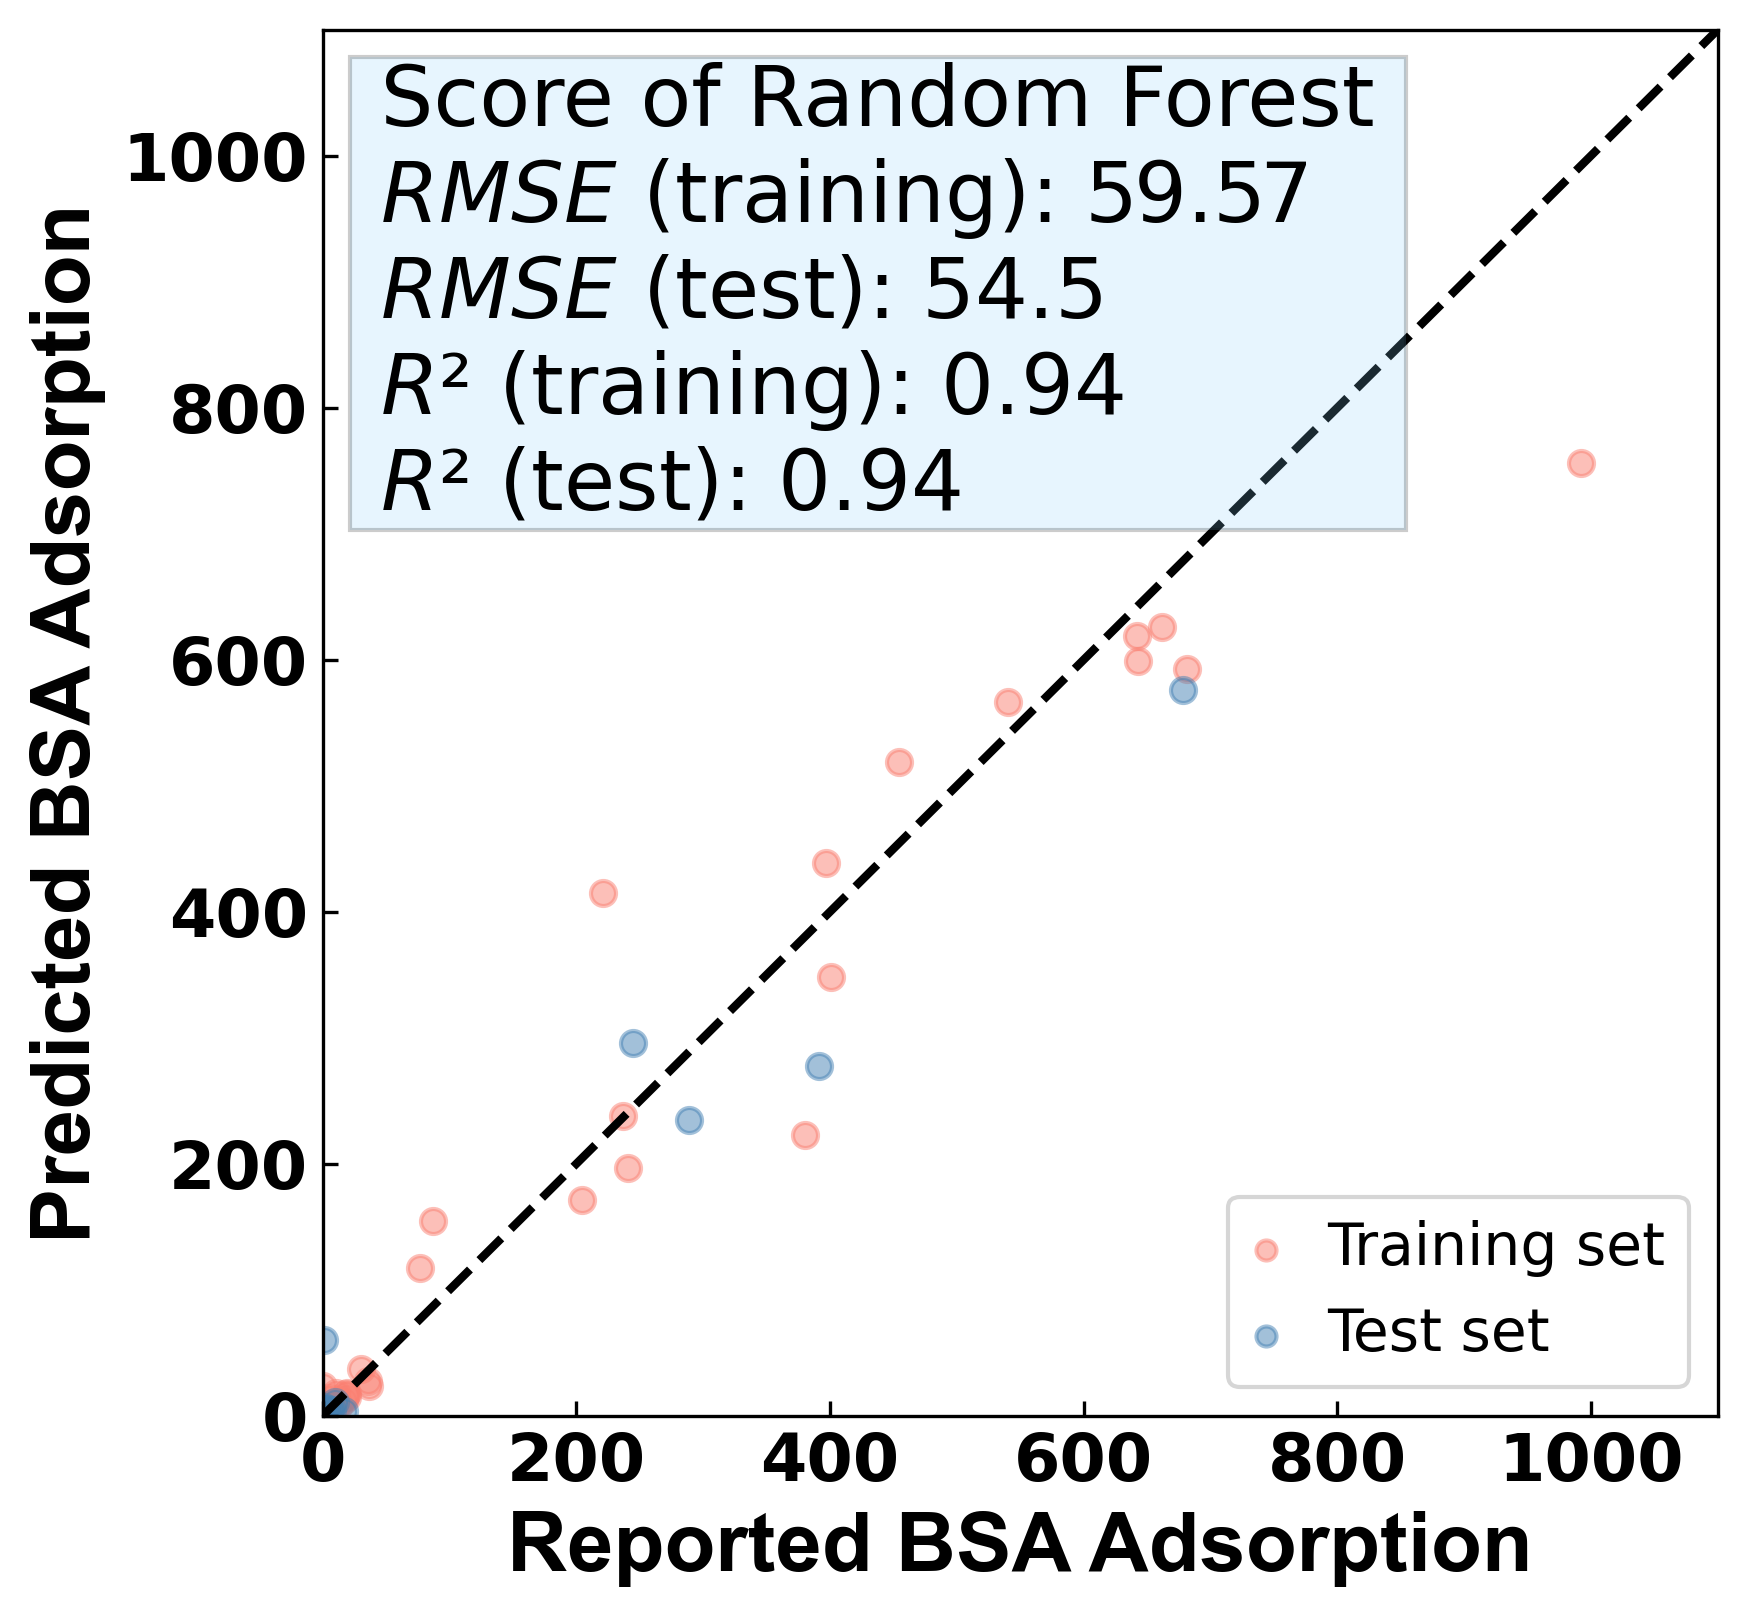

<Figure size 640x480 with 0 Axes>

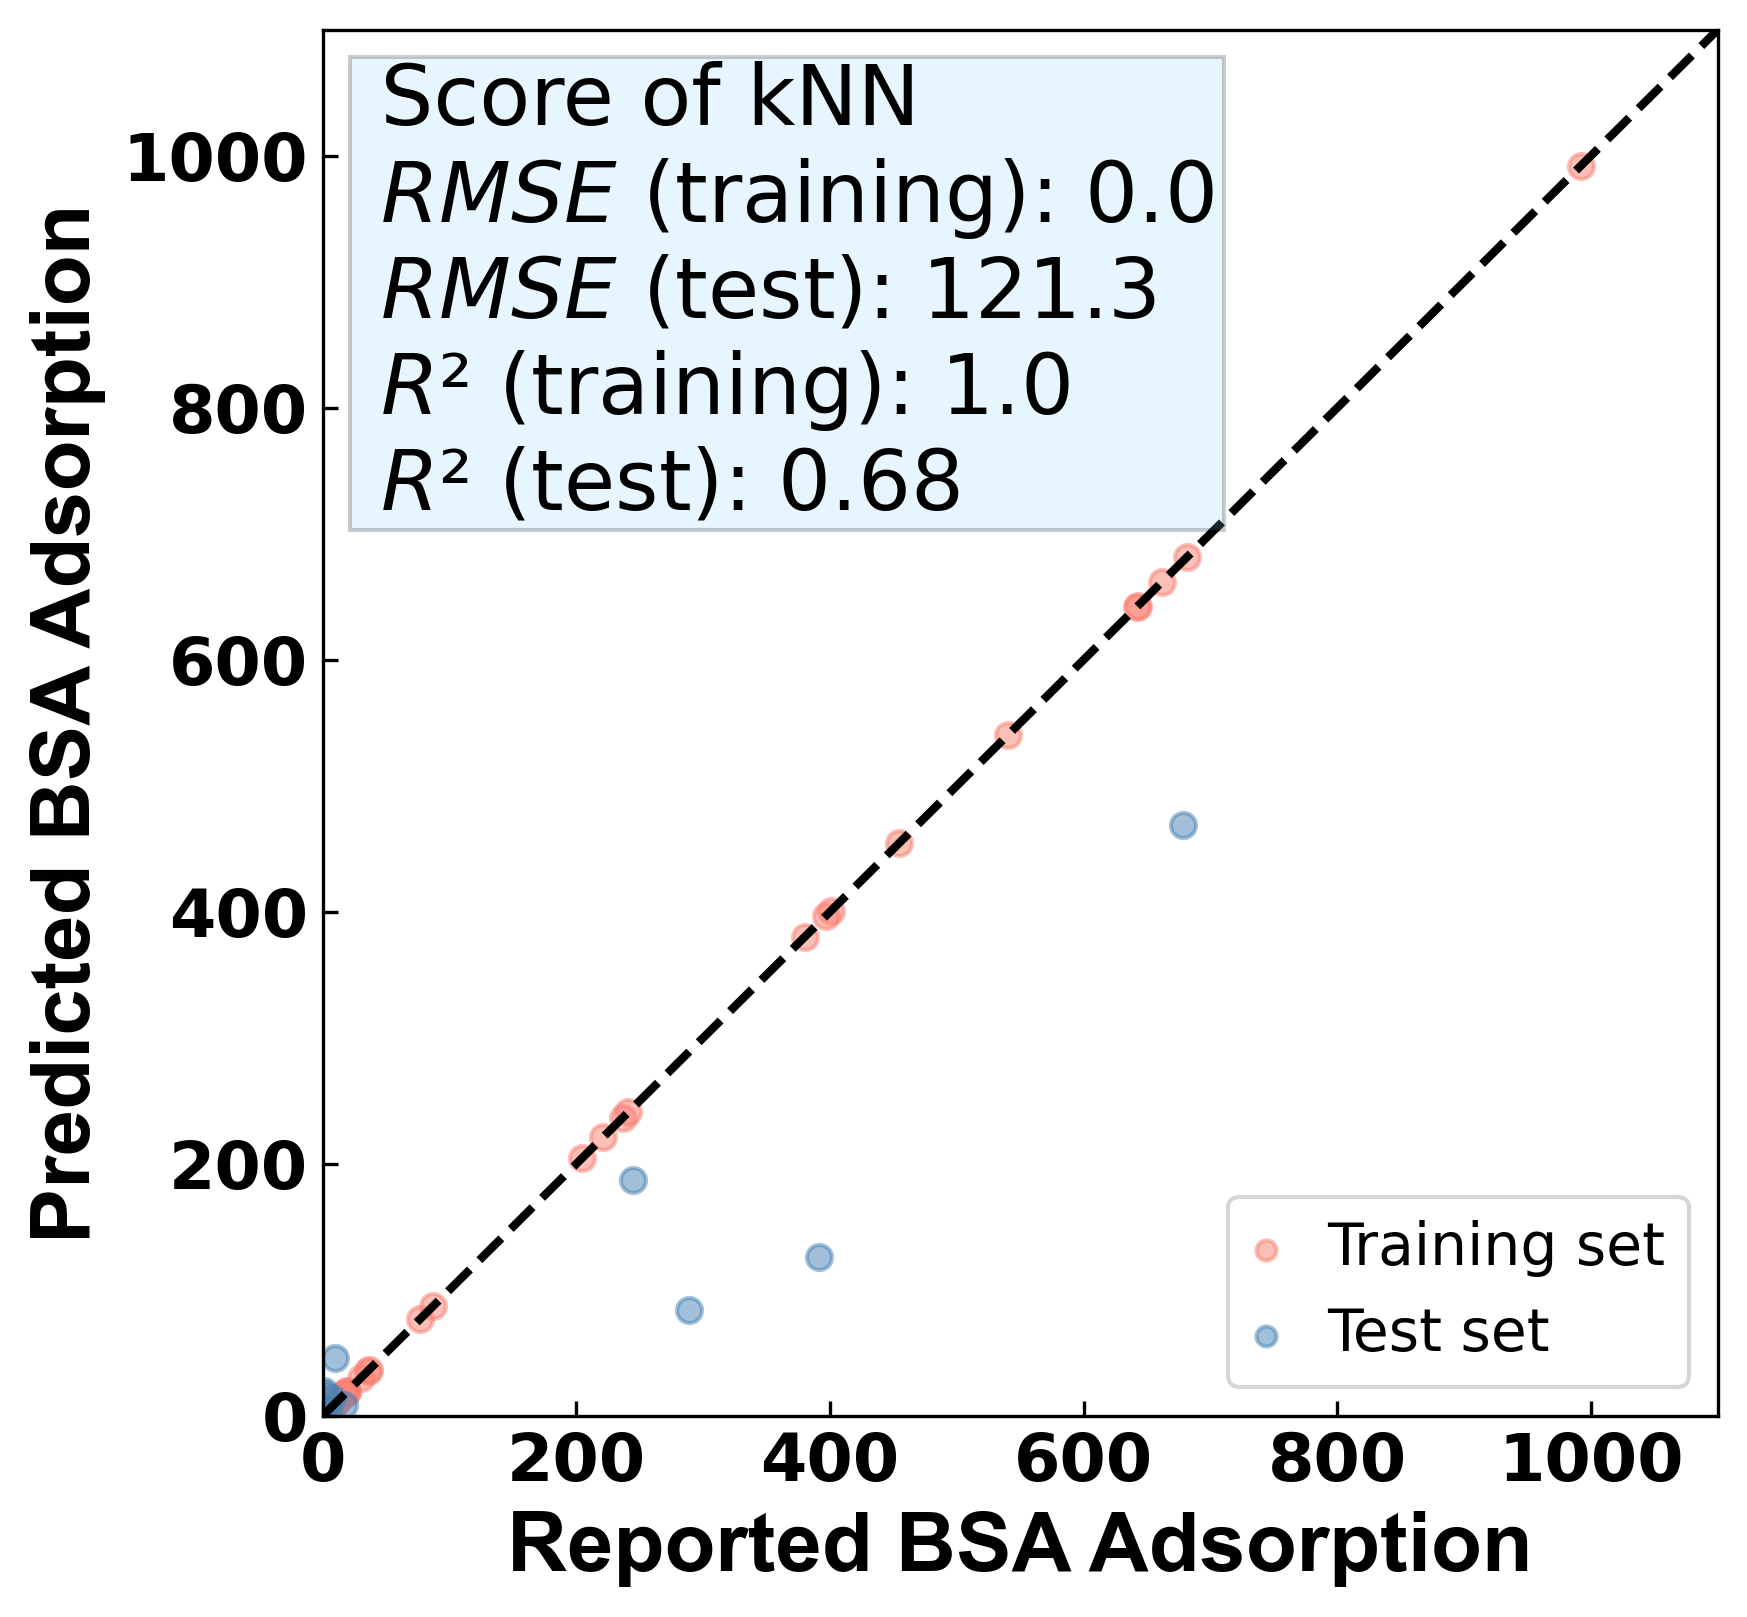

<Figure size 640x480 with 0 Axes>

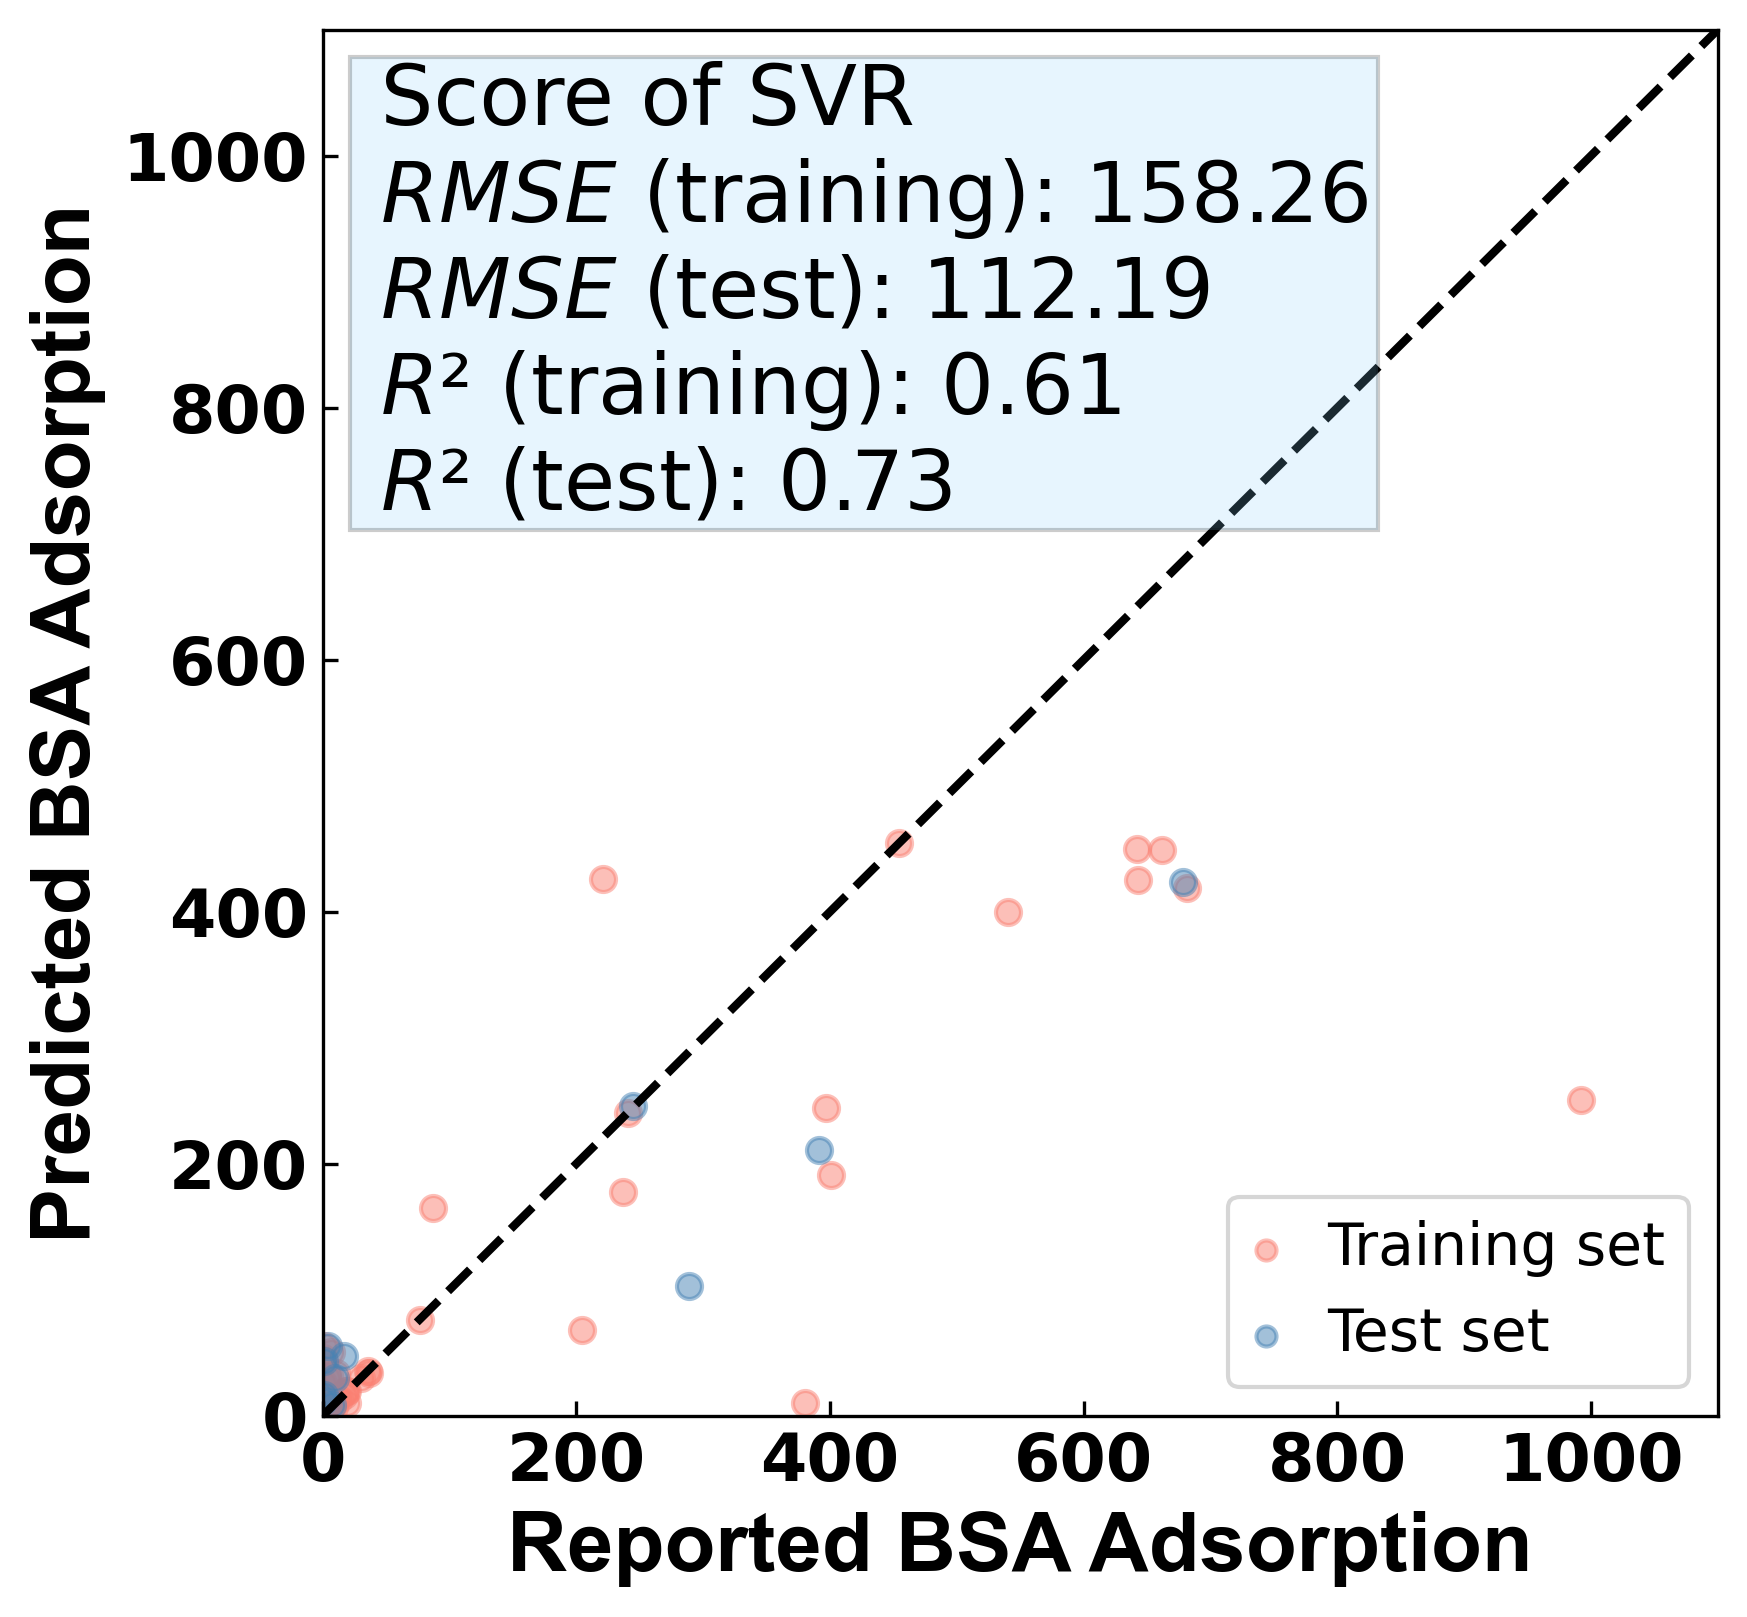

<Figure size 640x480 with 0 Axes>

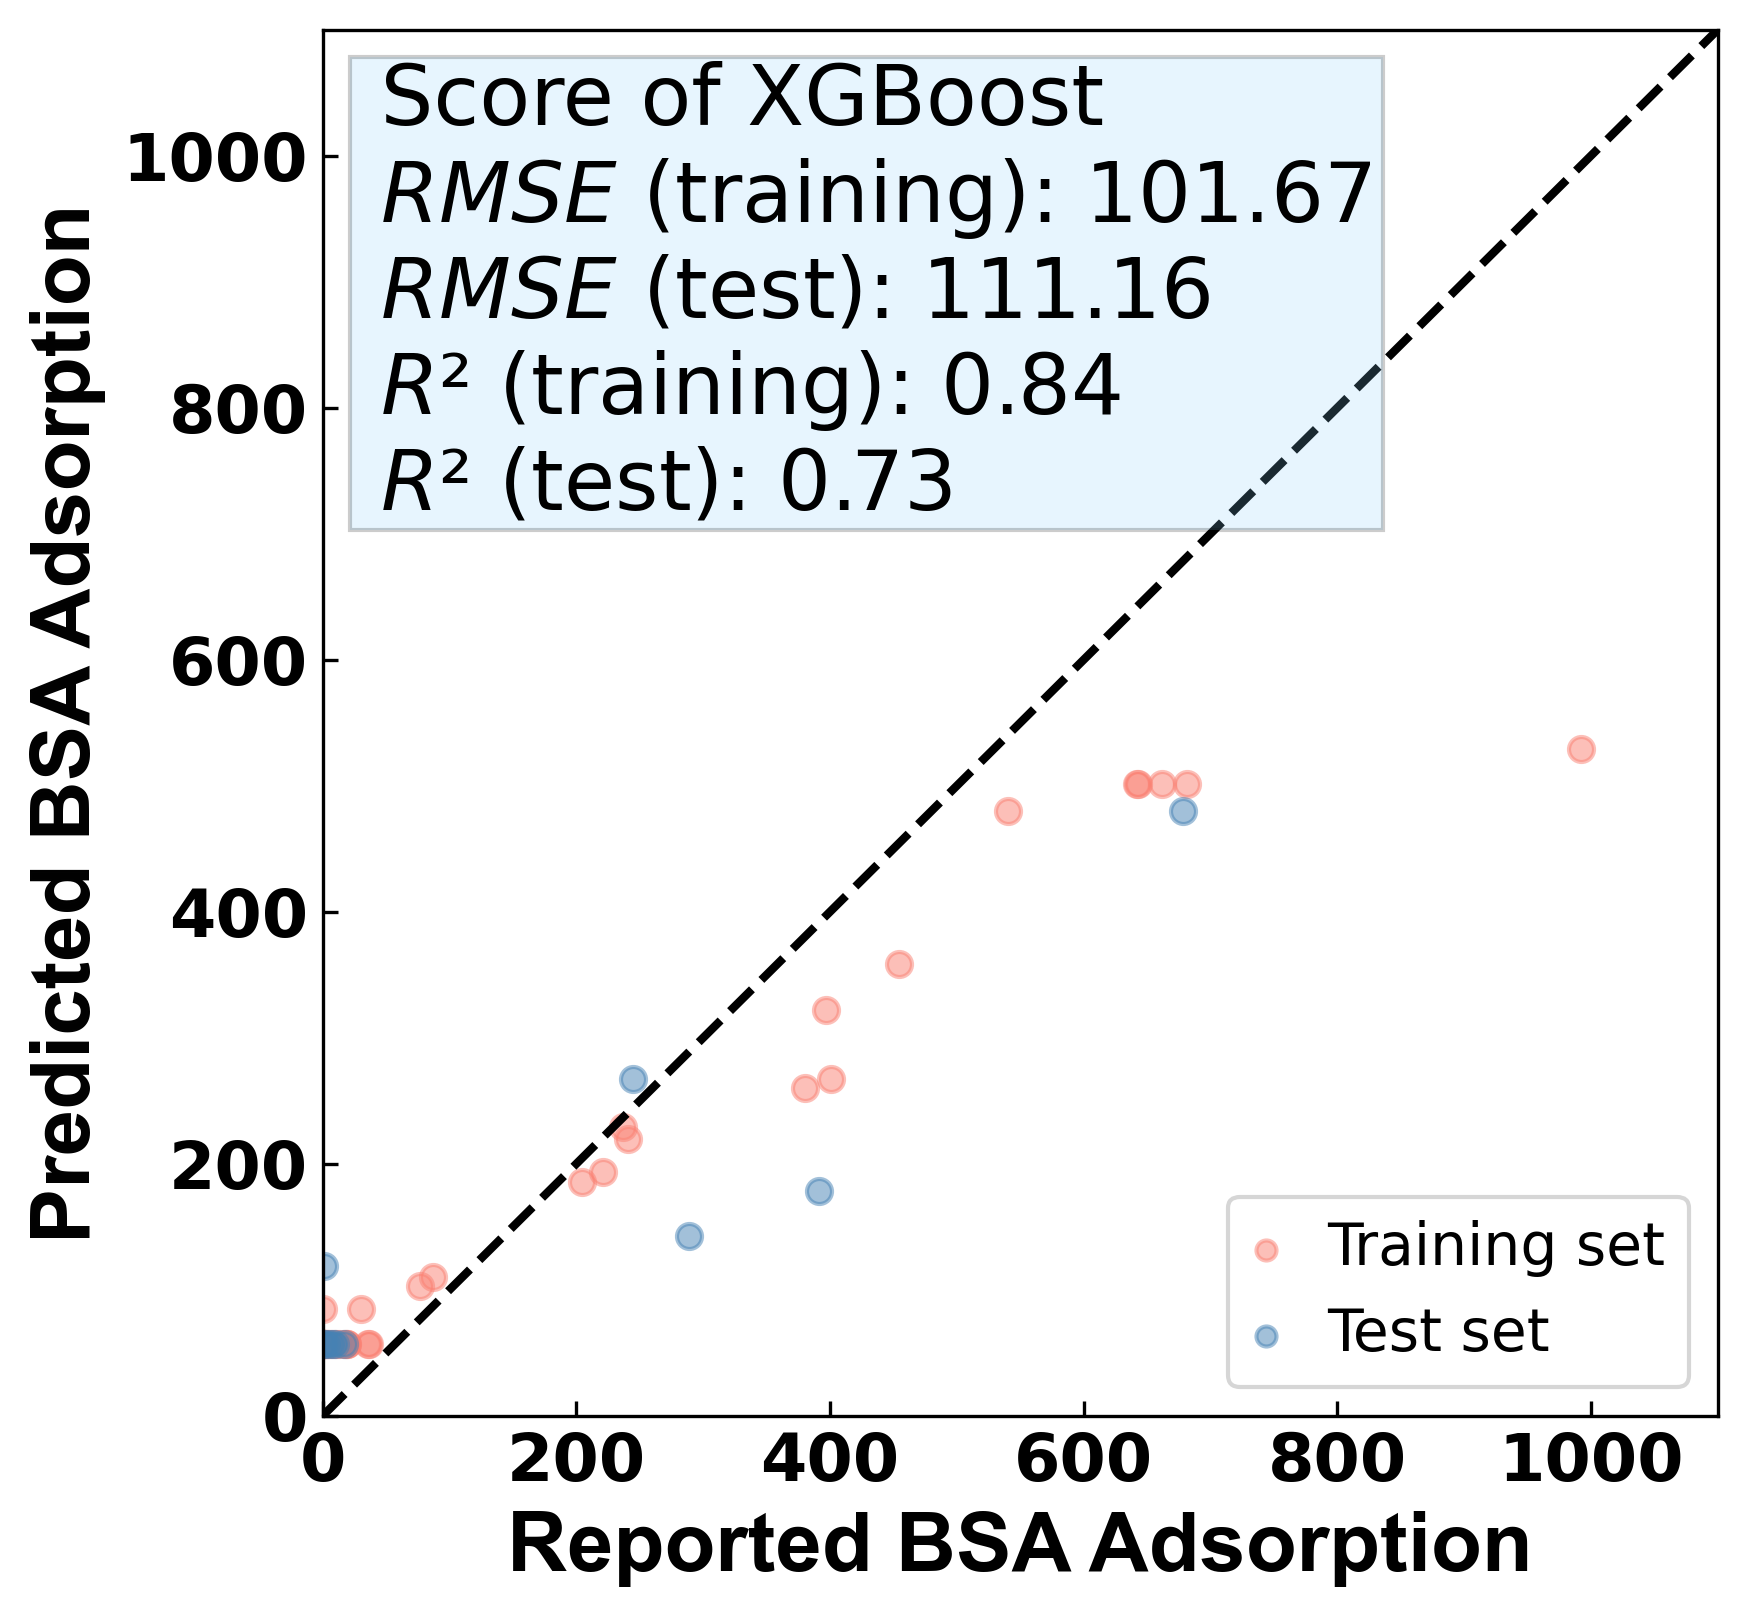

<Figure size 640x480 with 0 Axes>

In [22]:
models_name = ["LASSO", "Ridge", "Decision Tree", "Random Forest", "kNN", "SVR", "XGBoost"]

for i in range(len(trained_models_c)):
    result_show(trained_models_c[i], models_name[i], X_part_c, Y_part_array, X_val_c, Y_val_array)

model_output = "margin" has been renamed to model_output = "raw"
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


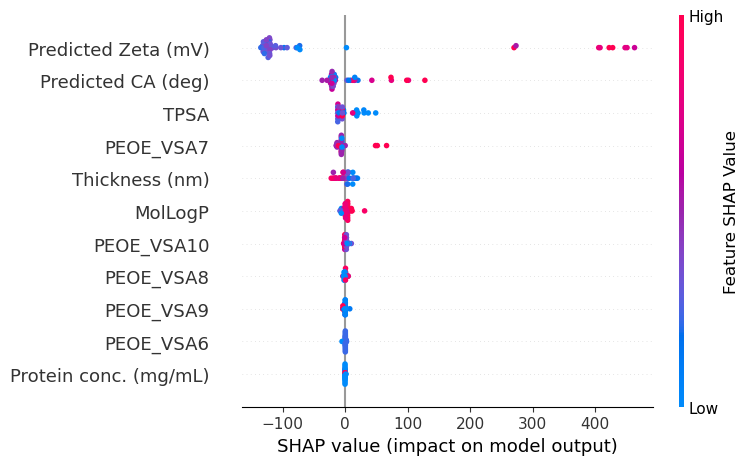

In [25]:
explainer = shap.TreeExplainer(model=trained_models_c[3],
                                feature_perturbation='tree_path_dependent',
                                model_output='margin')
shap_values = explainer.shap_values(X_part_c)
shap.summary_plot(shap_values, X_part_c, feature_names=df_c.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)